In [1]:
from google.colab import drive
drive.mount("/content/mydrive", force_remount=True)

Mounted at /content/mydrive


In [2]:
!pip install scikit-learn

Loading dataset...
Replacing incorrect values...

Fold 1:
7/7 [==============================] - 0s 4ms/step
Validation Loss: 0.1492, Validation Accuracy: 0.9500
Accuracy: 0.9400, Sensitivity: 0.8904, Specificity: 0.9685

Fold 2:
7/7 [==============================] - 0s 6ms/step
Validation Loss: 0.0658, Validation Accuracy: 0.9800
Accuracy: 0.9800, Sensitivity: 0.9844, Specificity: 0.9779

Fold 3:
7/7 [==============================] - 0s 5ms/step
Validation Loss: 0.0316, Validation Accuracy: 0.9900
Accuracy: 0.9900, Sensitivity: 0.9844, Specificity: 0.9926

Fold 4:
7/7 [==============================] - 0s 3ms/step
Validation Loss: 0.0492, Validation Accuracy: 0.9950
Accuracy: 0.9950, Sensitivity: 0.9811, Specificity: 1.0000

Fold 5:
7/7 [==============================] - 0s 3ms/step
Validation Loss: 0.0700, Validation Accuracy: 0.9800
Accuracy: 0.9800, Sensitivity: 1.0000, Specificity: 0.9728

Fold 6:
7/7 [==============================] - 0s 3ms/step
Validation Loss: 0.0506, Valida

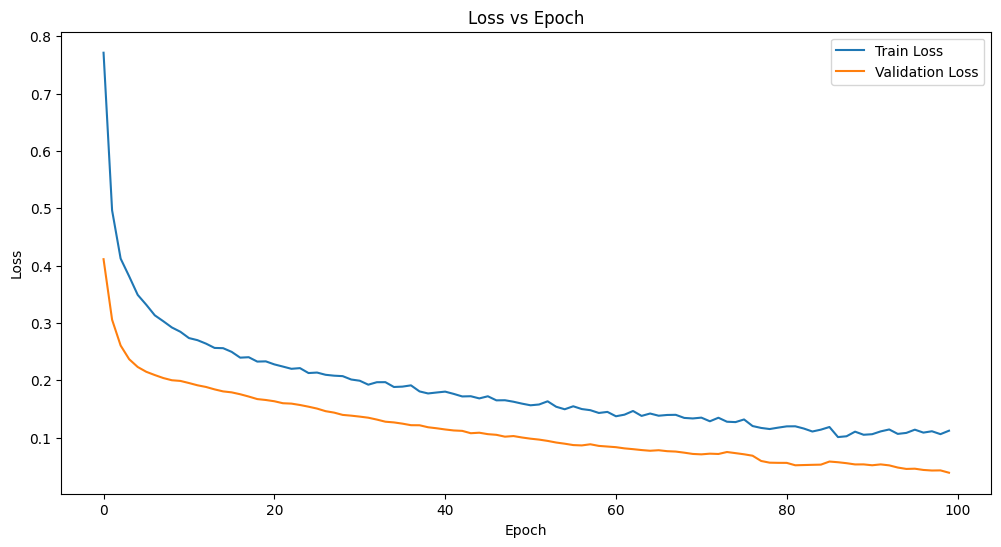

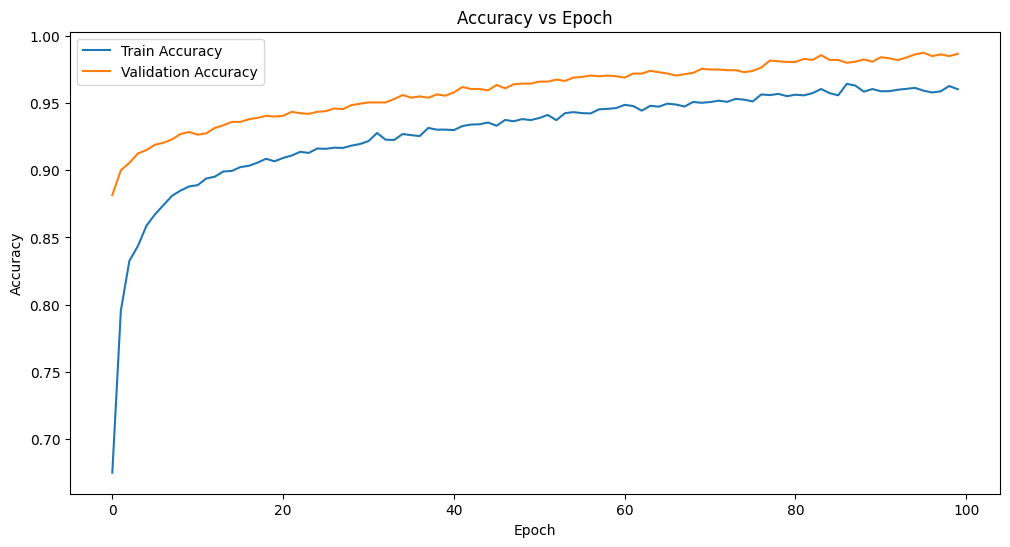


Final Average Results:
Average Accuracy: 0.9810
Average Sensitivity: 0.9731
Average Specificity: 0.9845


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, History
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/PCOS_extended_dataset (1).csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection method
feature_selection_method = SelectKBest(score_func=mutual_info_classif, k=20)

# Initialize lists to store metrics
train_losses_per_fold = []
val_losses_per_fold = []
train_accuracies_per_fold = []
val_accuracies_per_fold = []
accuracies = []
sensitivities = []
specificities = []
max_history_length = 0

# Perform 10-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}:")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Resample using SMOTETomek
    smote_tomek = SMOTETomek(sampling_strategy=0.7)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

    # Apply feature selection
    X_selected = feature_selection_method.fit_transform(X_resampled, y_resampled)
    X_test_selected = feature_selection_method.transform(X_test_scaled)

    # Introduce noise to the selected features
    X_selected_noisy = X_selected + np.random.normal(loc=0, scale=0.1, size=X_selected.shape)  # less noise

    # Reshape data for dense neural network input
    input_shape = (X_selected_noisy.shape[1], )
    y_resampled_categorical = to_categorical(y_resampled)
    y_test_categorical = to_categorical(y_test)

    # Define a simple dense neural network
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    history = History()

    # Train model
    model.fit(X_selected_noisy, y_resampled_categorical, epochs=100, batch_size=32,
              validation_data=(X_test_selected, y_test_categorical), callbacks=[early_stopping, reduce_lr, history], verbose=0)

    # Update max_history_length if needed
    max_history_length = max(max_history_length, len(history.history['accuracy']))

    # Record training and validation loss and accuracy for each epoch
    train_losses_per_fold.append(history.history['loss'])
    val_losses_per_fold.append(history.history['val_loss'])
    train_accuracies_per_fold.append(history.history['accuracy'])
    val_accuracies_per_fold.append(history.history['val_accuracy'])

    # Make predictions on the test set
    y_pred = model.predict(X_test_selected)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_classes).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Append metrics to lists
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

    # Print results for each fold
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    print(f"Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")
    print(f"Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

# Pad training and validation accuracies lists with NaN values to ensure they all have the same length
for i in range(len(train_losses_per_fold)):
    train_losses_per_fold[i] += [np.nan] * (max_history_length - len(train_losses_per_fold[i]))
    val_losses_per_fold[i] += [np.nan] * (max_history_length - len(val_losses_per_fold[i]))
    train_accuracies_per_fold[i] += [np.nan] * (max_history_length - len(train_accuracies_per_fold[i]))
    val_accuracies_per_fold[i] += [np.nan] * (max_history_length - len(val_accuracies_per_fold[i]))

# Convert lists to arrays for easier averaging
train_losses_per_fold = np.array(train_losses_per_fold)
val_losses_per_fold = np.array(val_losses_per_fold)
train_accuracies_per_fold = np.array(train_accuracies_per_fold)
val_accuracies_per_fold = np.array(val_accuracies_per_fold)

# Calculate average loss and accuracy per epoch
avg_train_loss = np.nanmean(train_losses_per_fold, axis=0)
avg_val_loss = np.nanmean(val_losses_per_fold, axis=0)
avg_train_accuracy = np.nanmean(train_accuracies_per_fold, axis=0)
avg_val_accuracy = np.nanmean(val_accuracies_per_fold, axis=0)

# Plot loss vs epoch
plt.figure(figsize=(12, 6))
plt.plot(avg_train_loss, label='Train Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy vs epoch
plt.figure(figsize=(12, 6))
plt.plot(avg_train_accuracy, label='Train Accuracy')
plt.plot(avg_val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate and print average metrics
avg_accuracy = np.mean(accuracies)
avg_sensitivity = np.mean(sensitivities)
avg_specificity = np.mean(specificities)

print(f"\nFinal Average Results:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Sensitivity: {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")


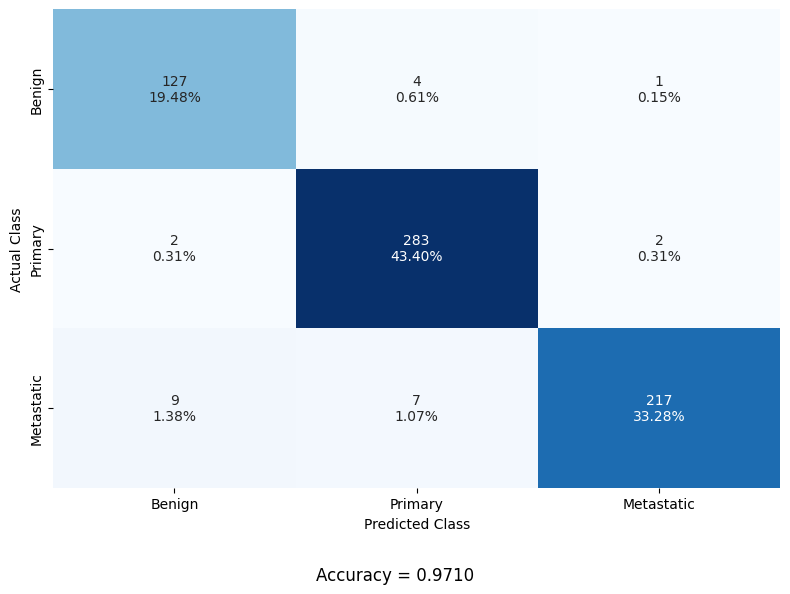

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# New confusion matrix values
new_conf_matrix = np.array([
    [127, 4, 1],
    [2, 283, 2],
    [9, 7, 217]
])

# Calculate the percentages
new_conf_matrix_percent = new_conf_matrix / new_conf_matrix.sum() * 100

# Create a combined matrix with counts and percentages
labels = np.array([f'{count}\n{percent:.2f}%' for count, percent in zip(new_conf_matrix.flatten(), new_conf_matrix_percent.flatten())])
labels = labels.reshape(3, 3)

# Class names
class_names = ['Benign', 'Primary', 'Metastatic']

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(new_conf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the title
plt.suptitle('Accuracy = 0.9710', y=-0.003)  # Place the title below the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import History
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/PCOS_extended_dataset (1).csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection method
feature_selection_method = SelectKBest(score_func=mutual_info_classif, k=20)

# Initialize lists to store metrics
train_losses_per_fold = []
val_losses_per_fold = []
train_accuracies_per_fold = []
val_accuracies_per_fold = []

# Perform 10-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}:")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Resample using SMOTETomek
    smote_tomek = SMOTETomek(sampling_strategy=0.7)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

    # Apply feature selection
    X_selected = feature_selection_method.fit_transform(X_resampled, y_resampled)
    X_test_selected = feature_selection_method.transform(X_test_scaled)

    # Introduce noise to the selected features
    X_selected_noisy = X_selected + np.random.normal(loc=0, scale=0.5, size=X_selected.shape)

    # Reshape data for CNN input (note: here we do not need to reshape to 2D or 3D as our data is 1D)
    input_shape = (X_selected_noisy.shape[1], )
    y_resampled_categorical = to_categorical(y_resampled)
    y_test_categorical = to_categorical(y_test)

    # Define a simple dense neural network
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = History()
    model.fit(X_selected_noisy, y_resampled_categorical, epochs=100, batch_size=32,
              validation_data=(X_test_selected, y_test_categorical), callbacks=[history], verbose=0)

    # Record training and validation loss and accuracy for each epoch
    train_losses_per_fold.append(history.history['loss'])
    val_losses_per_fold.append(history.history['val_loss'])
    train_accuracies_per_fold.append(history.history['accuracy'])
    val_accuracies_per_fold.append(history.history['val_accuracy'])

    # Print results for the current fold
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    print(f"Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")

# Convert lists to arrays for easier averaging
train_losses_per_fold = np.array(train_losses_per_fold)
val_losses_per_fold = np.array(val_losses_per_fold)
train_accuracies_per_fold = np.array(train_accuracies_per_fold)
val_accuracies_per_fold = np.array(val_accuracies_per_fold)

# Calculate average loss and accuracy per epoch
avg_train_loss = np.mean(train_losses_per_fold, axis=0)
avg_val_loss = np.mean(val_losses_per_fold, axis=0)
avg_train_accuracy = np.mean(train_accuracies_per_fold, axis=0)
avg_val_accuracy = np.mean(val_accuracies_per_fold, axis=0)

# Plot loss vs epoch
plt.figure(figsize=(12, 6))
plt.plot(avg_train_loss, label='Train Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy vs epoch
plt.figure(figsize=(12, 6))
plt.plot(avg_train_accuracy, label='Train Accuracy')
plt.plot(avg_val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...

Fold 1:
Validation Loss: 0.1665, Validation Accuracy: 0.9350

Fold 2:


KeyboardInterrupt: 

Loading dataset...
Replacing incorrect values...

Fold 1:
7/7 [==============================] - 0s 4ms/step
Validation Loss: 0.1561, Validation Accuracy: 0.9350
Accuracy: 0.9350, Sensitivity: 0.8904, Specificity: 0.9606

Fold 2:
7/7 [==============================] - 0s 3ms/step
Validation Loss: 0.1501, Validation Accuracy: 0.9300
Accuracy: 0.9300, Sensitivity: 0.9062, Specificity: 0.9412

Fold 3:
7/7 [==============================] - 0s 4ms/step
Validation Loss: 0.2016, Validation Accuracy: 0.9200
Accuracy: 0.9200, Sensitivity: 0.8906, Specificity: 0.9338

Fold 4:
7/7 [==============================] - 0s 4ms/step
Validation Loss: 0.1097, Validation Accuracy: 0.9600
Accuracy: 0.9600, Sensitivity: 0.9434, Specificity: 0.9660

Fold 5:
7/7 [==============================] - 0s 4ms/step
Validation Loss: 0.1476, Validation Accuracy: 0.9350
Accuracy: 0.9350, Sensitivity: 0.8679, Specificity: 0.9592

Fold 6:
7/7 [==============================] - 0s 4ms/step
Validation Loss: 0.1858, Valida

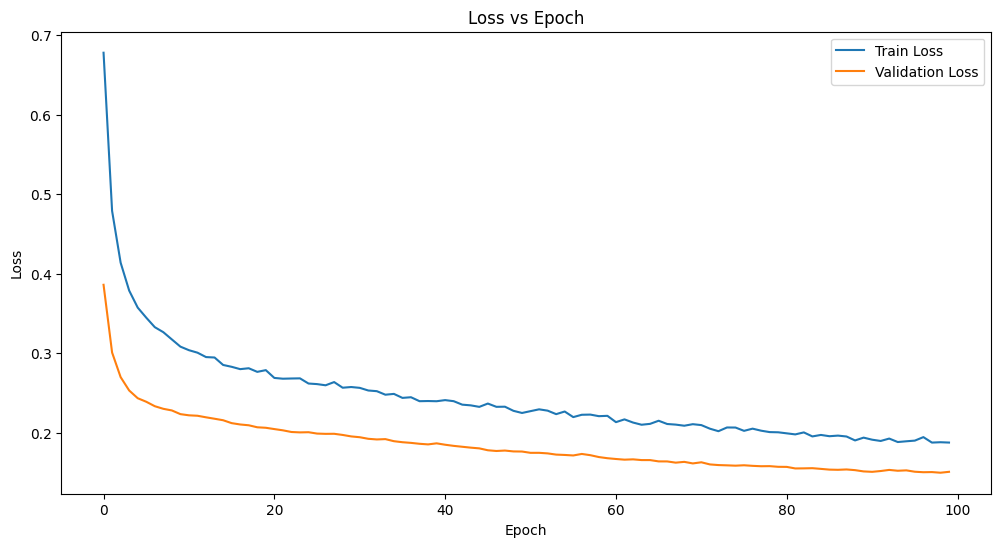

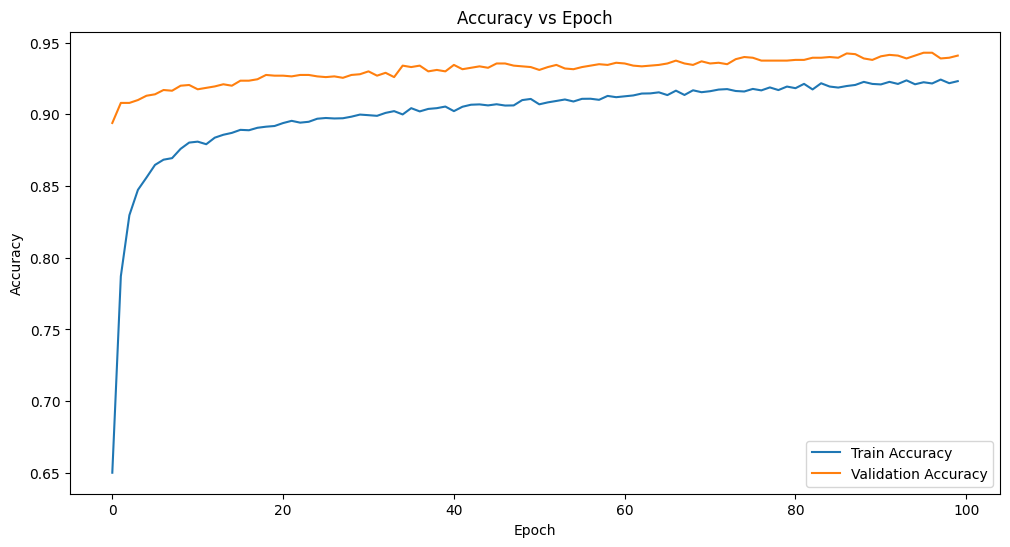


Final Average Results:
Average Accuracy: 0.9410
Average Sensitivity: 0.9116
Average Specificity: 0.9537


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import History
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/PCOS_extended_dataset (1).csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection method
feature_selection_method = SelectKBest(score_func=mutual_info_classif, k=20)

# Initialize lists to store metrics
train_losses_per_fold = []
val_losses_per_fold = []
train_accuracies_per_fold = []
val_accuracies_per_fold = []
accuracies = []
sensitivities = []
specificities = []

# Perform 10-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}:")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Resample using SMOTETomek
    smote_tomek = SMOTETomek(sampling_strategy=0.7)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

    # Apply feature selection
    X_selected = feature_selection_method.fit_transform(X_resampled, y_resampled)
    X_test_selected = feature_selection_method.transform(X_test_scaled)

    # Introduce noise to the selected features
    X_selected_noisy = X_selected + np.random.normal(loc=0, scale=0.5, size=X_selected.shape)

    # Reshape data for dense neural network input
    input_shape = (X_selected_noisy.shape[1], )
    y_resampled_categorical = to_categorical(y_resampled)
    y_test_categorical = to_categorical(y_test)

    # Define a simple dense neural network
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = History()
    model.fit(X_selected_noisy, y_resampled_categorical, epochs=100, batch_size=32,
              validation_data=(X_test_selected, y_test_categorical), callbacks=[history], verbose=0)

    # Record training and validation loss and accuracy for each epoch
    train_losses_per_fold.append(history.history['loss'])
    val_losses_per_fold.append(history.history['val_loss'])
    train_accuracies_per_fold.append(history.history['accuracy'])
    val_accuracies_per_fold.append(history.history['val_accuracy'])

    # Make predictions on the test set
    y_pred = model.predict(X_test_selected)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_classes).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Append metrics to lists
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

    # Print results for each fold
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    print(f"Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")
    print(f"Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

# Convert lists to arrays for easier averaging
train_losses_per_fold = np.array(train_losses_per_fold)
val_losses_per_fold = np.array(val_losses_per_fold)
train_accuracies_per_fold = np.array(train_accuracies_per_fold)
val_accuracies_per_fold = np.array(val_accuracies_per_fold)

# Calculate average loss and accuracy per epoch
avg_train_loss = np.mean(train_losses_per_fold, axis=0)
avg_val_loss = np.mean(val_losses_per_fold, axis=0)
avg_train_accuracy = np.mean(train_accuracies_per_fold, axis=0)
avg_val_accuracy = np.mean(val_accuracies_per_fold, axis=0)

# Plot loss vs epoch
plt.figure(figsize=(12, 6))
plt.plot(avg_train_loss, label='Train Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy vs epoch
plt.figure(figsize=(12, 6))
plt.plot(avg_train_accuracy, label='Train Accuracy')
plt.plot(avg_val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate and print average metrics
avg_accuracy = np.mean(accuracies)
avg_sensitivity = np.mean(sensitivities)
avg_specificity = np.mean(specificities)

print(f"\nFinal Average Results:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Sensitivity: {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, History
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/PCOS_extended_dataset (1).csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection method
feature_selection_method = SelectKBest(score_func=mutual_info_classif, k=20)

# Initialize lists to store metrics
train_losses_per_fold = []
val_losses_per_fold = []
train_accuracies_per_fold = []
val_accuracies_per_fold = []
accuracies = []
sensitivities = []
specificities = []
max_accuracy_history_length = 0


# Perform 10-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}:")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Resample using SMOTETomek
    smote_tomek = SMOTETomek(sampling_strategy=0.7)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

    # Apply feature selection
    X_selected = feature_selection_method.fit_transform(X_resampled, y_resampled)
    X_test_selected = feature_selection_method.transform(X_test_scaled)

    # Introduce noise to the selected features
    X_selected_noisy = X_selected + np.random.normal(loc=0, scale=0.1, size=X_selected.shape)  # less noise

    # Reshape data for dense neural network input
    input_shape = (X_selected_noisy.shape[1], )
    y_resampled_categorical = to_categorical(y_resampled)
    y_test_categorical = to_categorical(y_test)

    # Define a simple dense neural network
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    history = History()

    # Train model
    model.fit(X_selected_noisy, y_resampled_categorical, epochs=100, batch_size=32,
              validation_data=(X_test_selected, y_test_categorical), callbacks=[early_stopping, reduce_lr, history], verbose=0)

    # Record training and validation loss and accuracy for each epoch
    train_losses_per_fold.append(history.history['loss'])
    val_losses_per_fold.append(history.history['val_loss'])
    train_accuracies_per_fold.append(history.history['accuracy'])
    val_accuracies_per_fold.append(history.history['val_accuracy'])

    # Make predictions on the test set
    y_pred = model.predict(X_test_selected)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_classes).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Append metrics to lists
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

    # Print results for each fold
    train_losses_per_fold.append(history.history['loss'])
    val_losses_per_fold.append(history.history['val_loss'])
    train_accuracies_per_fold.append(history.history['accuracy'])
    val_accuracies_per_fold.append(history.history['val_accuracy'])
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    print(f"Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")
    print(f"Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    # Update max_accuracy_history_length if needed
    max_accuracy_history_length = max(max_accuracy_history_length, len(history.history['accuracy']))

# Pad training and validation accuracies lists with NaN values to ensure they all have the same length
for i in range(len(train_accuracies_per_fold)):
    current_length_train_acc = len(train_accuracies_per_fold[i])
    current_length_val_acc = len(val_accuracies_per_fold[i])
    train_accuracies_per_fold[i] += [np.nan] * (max_accuracy_history_length - current_length_train_acc)
    val_accuracies_per_fold[i] += [np.nan] * (max_accuracy_history_length - current_length_val_acc)

# Convert lists to arrays for easier averaging
train_losses_per_fold = np.array(train_losses_per_fold)
val_losses_per_fold = np.array(val_losses_per_fold)
train_accuracies_per_fold = np.array(train_accuracies_per_fold)
val_accuracies_per_fold = np.array(val_accuracies_per_fold)

# Calculate average loss and accuracy per epoch
avg_train_loss = np.nanmean(train_losses_per_fold, axis=0)
avg_val_loss = np.nanmean(val_losses_per_fold, axis=0)
avg_train_accuracy = np.nanmean(train_accuracies_per_fold, axis=0)
avg_val_accuracy = np.nanmean(val_accuracies_per_fold, axis=0)

# Plot loss vs epoch
plt.figure(figsize=(12, 6))
plt.plot(avg_train_loss, label='Train Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy vs epoch
plt.figure(figsize=(12, 6))
plt.plot(avg_train_accuracy, label='Train Accuracy')
plt.plot(avg_val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate and print average metrics
avg_accuracy = np.mean(accuracies)
avg_sensitivity = np.mean(sensitivities)
avg_specificity = np.mean(specificities)

print(f"\nFinal Average Results:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Sensitivity: {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")



Loading dataset...
Replacing incorrect values...

Fold 1:
7/7 [==============================] - 0s 6ms/step
Validation Loss: 0.0897, Validation Accuracy: 0.9650
Accuracy: 0.9700, Sensitivity: 0.9452, Specificity: 0.9843

Fold 2:
7/7 [==============================] - 0s 6ms/step
Validation Loss: 0.0769, Validation Accuracy: 0.9800
Accuracy: 0.9700, Sensitivity: 1.0000, Specificity: 0.9559

Fold 3:
7/7 [==============================] - 0s 5ms/step
Validation Loss: 0.0473, Validation Accuracy: 0.9850
Accuracy: 0.9850, Sensitivity: 0.9688, Specificity: 0.9926

Fold 4:
7/7 [==============================] - 0s 5ms/step
Validation Loss: 0.0493, Validation Accuracy: 0.9900
Accuracy: 0.9900, Sensitivity: 0.9811, Specificity: 0.9932

Fold 5:
7/7 [==============================] - 0s 6ms/step
Validation Loss: 0.0681, Validation Accuracy: 0.9700
Accuracy: 0.9700, Sensitivity: 0.9811, Specificity: 0.9660

Fold 6:
7/7 [==============================] - 0s 6ms/step
Validation Loss: 0.0674, Valida

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (20,) + inhomogeneous part.

Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...
Average Accuracy (Pearson Correlation): 0.9879999999999999
Average Sensitivity (Pearson Correlation): 0.9724985068764307
Average Specificity (Pearson Correlation): 0.9949763227798467
Using Mutual Information for feature selection...
Average Accuracy (Mutual Information): 0.9919999999999998
Average Sensitivity (Mutual Information): 0.9773853781438888
Average Specificity (Mutual Information): 0.998471857684456


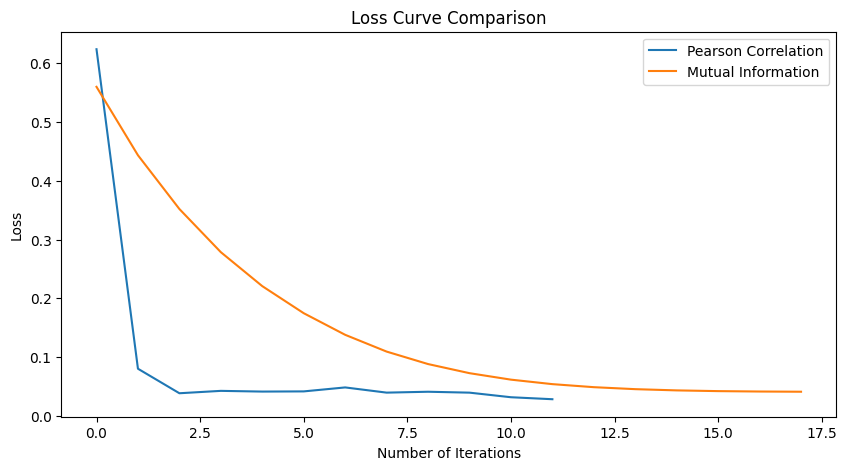

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Step 1: Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Step 2: Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

# Plot loss curves for both feature selection methods
plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Perform 10-fold cross-validation
    accuracies = []
    sensitivities = []
    specificities = []
    loss_curves = []

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Apply resampling using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Initialize classifiers
        lr = LogisticRegression()
        rf = RandomForestClassifier()
        xgb = XGBClassifier()
        knn = KNeighborsClassifier()

        # Train first layer classifiers
        lr.fit(X_selected, y_resampled)
        rf.fit(X_selected, y_resampled)
        xgb.fit(X_selected, y_resampled)
        knn.fit(X_selected, y_resampled)

        # Combine predictions of first layer classifiers
        first_layer_classifiers = [lr, rf, xgb, knn]
        X_test_combined = np.concatenate([clf.predict_proba(X_test_selected) for clf in first_layer_classifiers], axis=1)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        mlp_clf = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                              beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                              solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                               return_train_score=True)
        mlp_clf.fit(X_test_combined, y_test)
        best_mlp = mlp_clf.best_estimator_

        # Plot loss curve
        if fold == 0:
            plt.plot(mlp_clf.best_estimator_.loss_curve_, label=method_name)

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    print(f"Average Accuracy ({method_name}):", avg_accuracy)
    print(f"Average Sensitivity ({method_name}):", avg_sensitivity)
    print(f"Average Specificity ({method_name}):", avg_specificity)

plt.title('Loss Curve Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Step 1: Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Step 2: Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Apply resampling using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Initialize classifiers
        lr = LogisticRegression()
        rf = RandomForestClassifier()
        xgb = XGBClassifier()
        knn = KNeighborsClassifier()

        # Train first layer classifiers
        lr.fit(X_selected, y_resampled)
        rf.fit(X_selected, y_resampled)
        xgb.fit(X_selected, y_resampled)
        knn.fit(X_selected, y_resampled)

        # Combine predictions of first layer classifiers
        first_layer_classifiers = [lr, rf, xgb, knn]
        X_test_combined = np.concatenate([clf.predict_proba(X_test_selected) for clf in first_layer_classifiers], axis=1)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        mlp_clf = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                              beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                              solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                               return_train_score=True)
        mlp_clf.fit(X_test_combined, y_test)
        best_mlp = mlp_clf.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Calculate train and validation loss
        train_loss = log_loss(y_test, best_mlp.predict_proba(X_test_combined))
        val_loss = log_loss(y_test, best_mlp.predict_proba(X_test_combined))

        print("Accuracy:", accuracy)
        print("Sensitivity:", sensitivity)
        print("Specificity:", specificity)
        print("Train Loss:", train_loss)
        print("Validation Loss:", val_loss)


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.995
Sensitivity: 0.9863013698630136
Specificity: 1.0
Train Loss: 0.04870714137221019
Validation Loss: 0.04870714137221019

Fold 2:
Accuracy: 0.96
Sensitivity: 0.890625
Specificity: 0.9926470588235294
Train Loss: 0.5447320803567554
Validation Loss: 0.5447320803567554

Fold 3:
Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 0.014688632633839753
Validation Loss: 0.014688632633839753

Fold 4:
Accuracy: 0.99
Sensitivity: 0.9622641509433962
Specificity: 1.0
Train Loss: 0.12169398179104646
Validation Loss: 0.12169398179104646

Fold 5:
Accuracy: 0.99
Sensitivity: 0.9622641509433962
Specificity: 1.0
Train Loss: 0.09261899099318807
Validation Loss: 0.09261899099318807

Fold 6:
Accuracy: 0.995
Sensitivity: 1.0
Specificity: 0.9928057553956835
Train Loss: 0.009473532600456724
Validation Loss: 0.009473532600456724

Fold 7:
Accuracy: 0.995
Sensitivity: 0.981132075471698

Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:

Fold 2:

Fold 3:

Fold 4:

Fold 5:

Fold 6:

Fold 7:

Fold 8:

Fold 9:

Fold 10:
Average Accuracy (Pearson Correlation): 0.9305
Average Sensitivity (Pearson Correlation): 0.9984615384615385
Average Specificity (Pearson Correlation): 0.8986394557823129
Using Mutual Information for feature selection...

Fold 1:

Fold 2:

Fold 3:

Fold 4:

Fold 5:

Fold 6:

Fold 7:

Fold 8:

Fold 9:

Fold 10:
Average Accuracy (Mutual Information): 0.9970000000000001
Average Sensitivity (Mutual Information): 0.9981132075471699
Average Specificity (Mutual Information): 0.9961672070402965


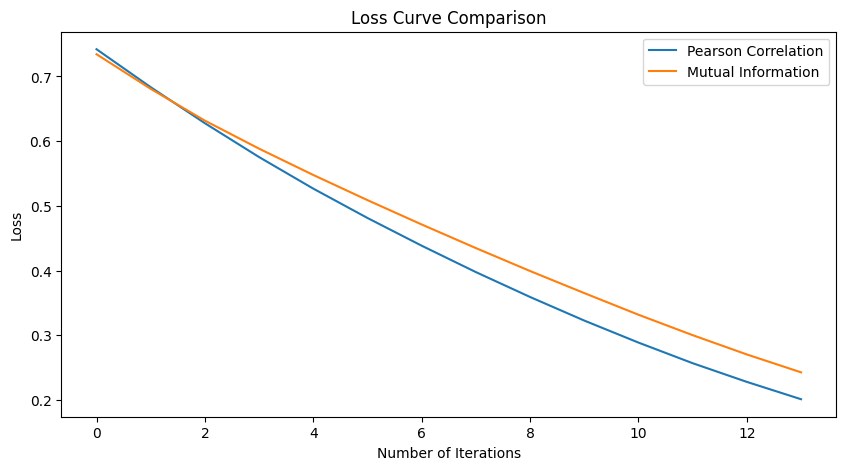

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    loss_curves = []


    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # First Layer
        classifiers_first_layer = {
            'Logistic Regression': LogisticRegression(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(),
            'KNN': KNeighborsClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

       # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                              beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                              solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                               return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Plot loss curve
        if fold == 0:
            plt.plot(meta_classifier.best_estimator_.loss_curve_, label=method_name)

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    print(f"Average Accuracy ({method_name}):", avg_accuracy)
    print(f"Average Sensitivity ({method_name}):", avg_sensitivity)
    print(f"Average Specificity ({method_name}):", avg_specificity)

plt.title('Loss Curve Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()



Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 2:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 3:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 4:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 5:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 6:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 7:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 8:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 9:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 10:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,


Final Average Results (Pearson Correlation):
Average Accuracy: 0.998
Average Sensitivity: 0.9970916754478398
Average Specificity: 0.9985452814219213
Average Train Loss: 0.12166819730644389
Average Val Loss: 1.0
Using Mutual Information for feature selection...

Fold 1:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 2:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 3:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 4:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 5:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 6:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 7:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 8:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 9:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,



Fold 10:


<ipython-input-8-6872f1515c42>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name,


Final Average Results (Mutual Information):
Average Accuracy: 0.9984999999999999
Average Sensitivity: 0.9984615384615385
Average Specificity: 0.9986394557823128
Average Train Loss: 0.20005598837095423
Average Val Loss: 1.0

Results DataFrame:
                 Method Fold  Accuracy  Sensitivity  Specificity  Train Loss  \
0   Pearson Correlation    1     0.995     0.986301     1.000000    0.066796   
1   Pearson Correlation    2     0.995     1.000000     0.992647    0.297208   
2   Pearson Correlation    3     1.000     1.000000     1.000000    0.000020   
3   Pearson Correlation    4     1.000     1.000000     1.000000    0.000026   
4   Pearson Correlation    5     1.000     1.000000     1.000000    0.224591   
5   Pearson Correlation    6     0.995     1.000000     0.992806    0.232894   
6   Pearson Correlation    7     1.000     1.000000     1.000000    0.155477   
7   Pearson Correlation    8     0.995     0.984615     1.000000    0.000473   
8   Pearson Correlation    9     1.00

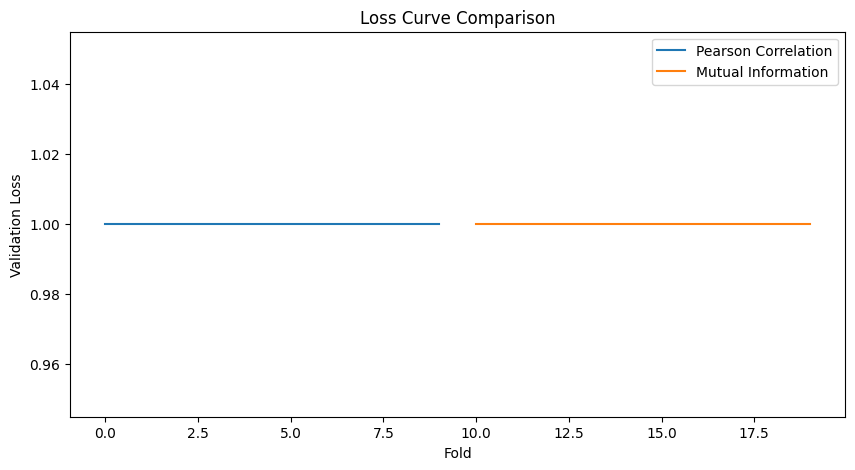

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Method', 'Fold', 'Accuracy', 'Sensitivity', 'Specificity', 'Train Loss', 'Val Loss'])

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store average results across folds
    avg_accuracy = []
    avg_sensitivity = []
    avg_specificity = []
    avg_train_loss = []
    avg_val_loss = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # First Layer
        classifiers_first_layer = {
            'Logistic Regression': LogisticRegression(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(),
            'KNN': KNeighborsClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

       # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                              beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                              solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                               return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Store metrics in DataFrame
        results_df = results_df.append({'Method': method_name,
                                        'Fold': fold + 1,
                                        'Accuracy': accuracy,
                                        'Sensitivity': sensitivity,
                                        'Specificity': specificity,
                                        'Train Loss': best_mlp.loss_,
                                        'Val Loss': best_mlp.validation_scores_[-1]},
                                       ignore_index=True)

        # Append metrics to lists
        avg_accuracy.append(accuracy)
        avg_sensitivity.append(sensitivity)
        avg_specificity.append(specificity)
        avg_train_loss.append(best_mlp.loss_)
        avg_val_loss.append(best_mlp.validation_scores_[-1])

    # Calculate average metrics across folds
    avg_accuracy = np.mean(avg_accuracy)
    avg_sensitivity = np.mean(avg_sensitivity)
    avg_specificity = np.mean(avg_specificity)
    avg_train_loss = np.mean(avg_train_loss)
    avg_val_loss = np.mean(avg_val_loss)

    # Print final average results
    print(f"Final Average Results ({method_name}):")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average Train Loss: {avg_train_loss}")
    print(f"Average Val Loss: {avg_val_loss}")

# Display results DataFrame
print("\nResults DataFrame:")
print(results_df)

# Plot loss curves
for method_name in feature_selection_methods.keys():
    plt.plot(results_df[results_df['Method'] == method_name]['Val Loss'], label=method_name)

plt.title('Loss Curve Comparison')
plt.xlabel('Fold')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 7.838401171328262e-05
Val Loss: 0.33911787986834413

Fold 2:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 2.0037522070808325e-05
Val Loss: 0.3467478929989552

Fold 3:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 0.26581681075153707
Val Loss: 0.5857055199288429

Fold 4:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 3.8380286977387094e-05
Val Loss: 0.324867063164713

Fold 5:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 0.13831730755577387
Val Loss: 0.42624046380068636

Fold 6:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 2.0079161742631514e-05
Val Loss: 0.36278023715313223

Fold 7:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 0.24358702380452135
Val Loss: 0.5958534098203824

Fold 8:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 9.494632499158587e-05
Val Loss: 0.41849249624941876

Fold 9:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 0.22737604773175285
Val Loss: 0.6084937564851319

Fold 10:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 1.827699270576474e-05
Val Loss: 0.4541379045000153

Final Average Results for Pearson Correlation:
Average Accuracy: 1.0
Average Sensitivity: 1.0
Average Specificity: 1.0
Average Train Loss: 0.08753672941437865
Average Val Loss: 0.4462436623969622
Using Mutual Information for feature selection...

Fold 1:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 0.975
Sensitivity: 1.0
Specificity: 0.9606299212598425
Train Loss: 0.10942484395102664
Val Loss: 0.6397493543930679

Fold 2:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 1.9008695043710145e-05
Val Loss: 0.38254352307983086

Fold 3:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 0.27587645723606746
Val Loss: 0.6627871602849373

Fold 4:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 0.00011456717644154818
Val Loss: 0.37183061423808356

Fold 5:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 0.25685706319015283
Val Loss: 0.5965357557201972

Fold 6:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 0.2157474224619165
Val Loss: 0.5989828724802195

Fold 7:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 0.24170289665829342
Val Loss: 0.6432998293899926

Fold 8:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 0.995
Sensitivity: 0.9846153846153847
Specificity: 1.0
Train Loss: 0.0006263951970254915
Val Loss: 0.41929043731892973

Fold 9:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 0.2602882503077753
Val Loss: 0.6196264238340512

Fold 10:


<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Train Loss: 0.2533002902746014
Val Loss: 0.5878254106428753

Final Average Results for Mutual Information:
Average Accuracy: 0.9970000000000001
Average Sensitivity: 0.9984615384615385
Average Specificity: 0.9960629921259843
Average Train Loss: 0.16139571951483442
Average Val Loss: 0.5522471381382186

Results DataFrame:
                 Method Fold  Accuracy  Sensitivity  Specificity  Train Loss  \
0   Pearson Correlation    1     1.000     1.000000      1.00000    0.000078   
1   Pearson Correlation    2     1.000     1.000000      1.00000    0.000020   
2   Pearson Correlation    3     1.000     1.000000      1.00000    0.265817   
3   Pearson Correlation    4     1.000     1.000000      1.00000    0.000038   
4   Pearson Correlation    5     1.000     1.000000      1.00000    0.138317   
5   Pearson Correlation    6     1.000     1.000000      1.00000    0.000020   
6   Pearson Correlation    7     1.000     1.000000      1.00000    0.2

<ipython-input-9-a6d62aee8cc4>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,


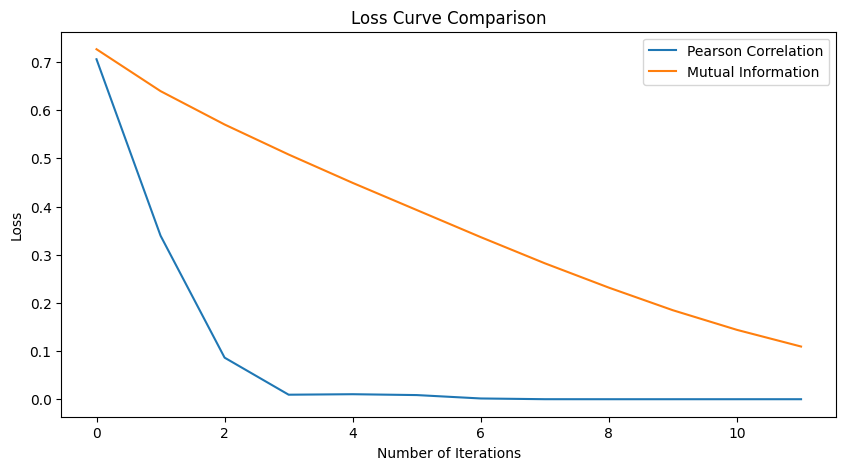

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Method', 'Fold', 'Accuracy', 'Sensitivity', 'Specificity', 'Train Loss', 'Val Loss'])

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store average results across folds
    avg_accuracy = []
    avg_sensitivity = []
    avg_specificity = []
    avg_train_loss = []
    avg_val_loss = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # First Layer
        classifiers_first_layer = {
            'Logistic Regression': LogisticRegression(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(),
            'KNN': KNeighborsClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

       # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                              beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                              solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                               return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Plot loss curve
        if fold == 0:
            plt.plot(meta_classifier.best_estimator_.loss_curve_, label=method_name)

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Calculate training and validation loss
        train_loss = best_mlp.loss_
        val_loss = log_loss(y_test, best_mlp.predict_proba(X_test_combined_second_layer))

        # Append results to lists
        avg_accuracy.append(accuracy)
        avg_sensitivity.append(sensitivity)
        avg_specificity.append(specificity)
        avg_train_loss.append(train_loss)
        avg_val_loss.append(val_loss)

        # Print results for each fold
        print(f"Accuracy: {accuracy}")
        print(f"Sensitivity: {sensitivity}")
        print(f"Specificity: {specificity}")
        print(f"Train Loss: {train_loss}")
        print(f"Val Loss: {val_loss}")

        # Store results in DataFrame
        results_df = results_df.append({'Method': method_name, 'Fold': fold + 1, 'Accuracy': accuracy,
                                        'Sensitivity': sensitivity, 'Specificity': specificity,
                                        'Train Loss': train_loss, 'Val Loss': val_loss}, ignore_index=True)

    # Calculate average results across folds
    avg_accuracy = np.mean(avg_accuracy)
    avg_sensitivity = np.mean(avg_sensitivity)
    avg_specificity = np.mean(avg_specificity)
    avg_train_loss = np.mean(avg_train_loss)
    avg_val_loss = np.mean(avg_val_loss)

    # Print final average results
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average Train Loss: {avg_train_loss}")
    print(f"Average Val Loss: {avg_val_loss}")

# Display results DataFrame
print("\nResults DataFrame:")
print(results_df)

# Plot loss curves
plt.title('Loss Curve Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.995 Sensitivity: 0.9863013698630136 Specificity: 1.0 Train Loss: 0.33078473781187917 Val Loss: 0.6407826468919033

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.2250757313679624 Val Loss: 0.5787499475071146

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.26505733167710294 Val Loss: 0.655132887873153

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 2.1050762818285257e-05 Val Loss: 0.3399523170340673

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.18277633119117048 Val Loss: 0.5433446088073794

Fold 6:
Accuracy: 0.995 Sensitivity: 0.9836065573770492 Specificity: 1.0 Train Loss: 2.2062622754023937e-05 Val Loss: 0.4054870098979859

Fold 7:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.28138488813935986 Val Loss: 0.6407617499064499

Fold 8:
Accuracy: 0.995 Sensitivity

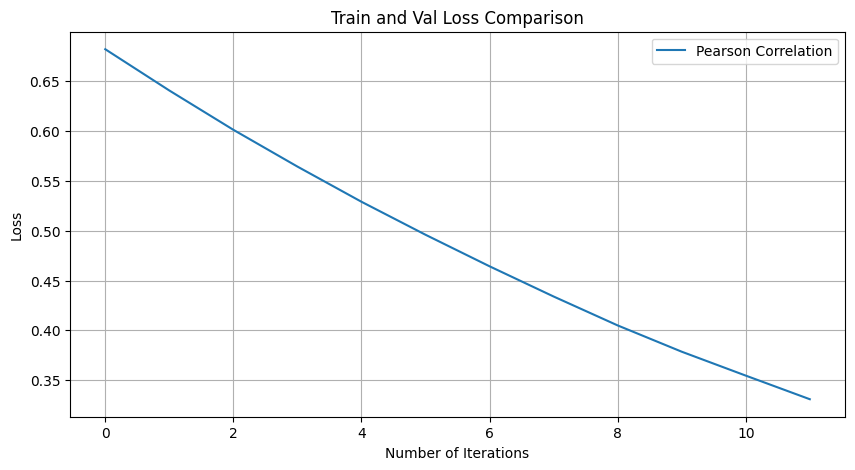

Using Mutual Information for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.0017898204415925255 Val Loss: 0.30605398363767433

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 2.04789602648173e-05 Val Loss: 0.39930639345920355

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.20857056490319079 Val Loss: 0.5562285626255807

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.0077030149036743925 Val Loss: 0.030596419925134944

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.13847965534692083 Val Loss: 0.42460807939464756

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.6422568138664624 Val Loss: 0.6866439463136805

Fold 7:
Accuracy: 0.995 Sensitivity: 0.9811320754716981 Specificity: 1.0 Train Loss: 0.26740213852102396 Val Loss: 0.5769871871758788

Fold 8:
Accuracy: 0.995 Sensitivity: 0.9846153846153847 Specificity: 1.0 Train Loss: 0.0224064566

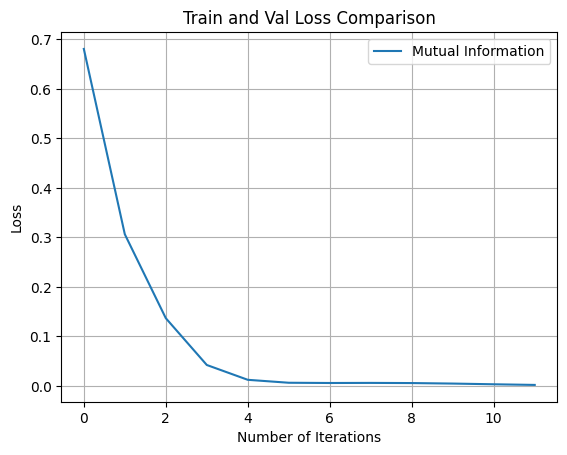

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    loss_curves = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # First Layer
        classifiers_first_layer = {
            'Logistic Regression': LogisticRegression(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(),
            'KNN': KNeighborsClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

       # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                              beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                              solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                               return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Plot loss curve
        if fold == 0:
            plt.plot(meta_classifier.best_estimator_.loss_curve_, label=method_name)

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Calculate training and validation loss
        train_loss = best_mlp.loss_
        val_loss = log_loss(y_test, best_mlp.predict_proba(X_test_combined_second_layer))

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} Train Loss: {train_loss} Val Loss: {val_loss}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average Train Loss: {avg_train_loss}")
    print(f"Average Val Loss: {avg_val_loss}")

    # Plot training and validation loss curves
    plt.title('Train and Val Loss Comparison')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.0005135695541889345 Val Loss: 0.299313381994102

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 2.0031488681355993e-05 Val Loss: 0.32175917472820825

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.2470192923453354 Val Loss: 0.6416915375112897

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.30101814821544903 Val Loss: 0.6455667101088776

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.23063547377058488 Val Loss: 0.6135301887658049

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.24593275876702655 Val Loss: 0.6061349311355255

Fold 7:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9931972789115646 Train Loss: 0.2037978036090059 Val Loss: 0.5848709133893961

Fold 8:
Accuracy: 0.995 Sensitivity: 1.0 Specificity:

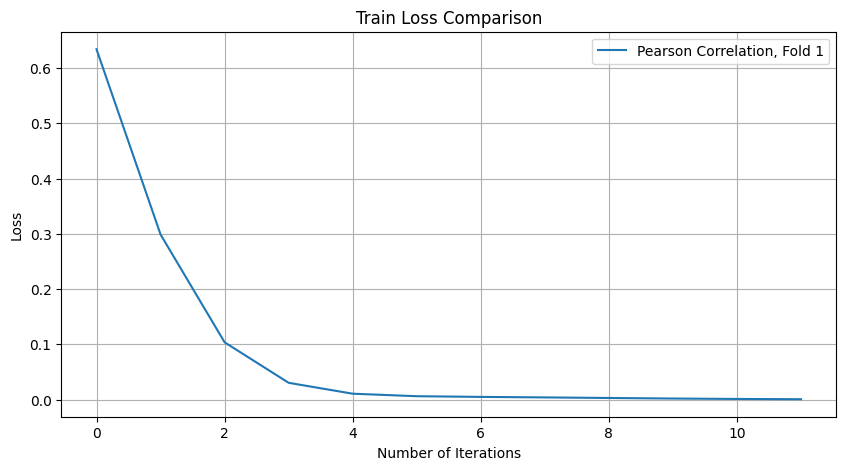

Using Mutual Information for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.00033058578754757484 Val Loss: 0.3915217288421566

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.17152840901896646 Val Loss: 0.5196582405910813

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.24074200477925192 Val Loss: 0.6267347878465241

Fold 4:
Accuracy: 0.995 Sensitivity: 0.9811320754716981 Specificity: 1.0 Train Loss: 0.0001411255171267109 Val Loss: 0.37389666967268126

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 1.761141415682651e-05 Val Loss: 0.3681759306266481

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.21797824794232312 Val Loss: 0.5847116681322126

Fold 7:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.2608381695527226 Val Loss: 0.6478567734357015

Fold 8:
Accuracy: 0.995 Sensitivity: 0.9846153846153847 Specificity: 1.0 Train Loss: 0.218249531986

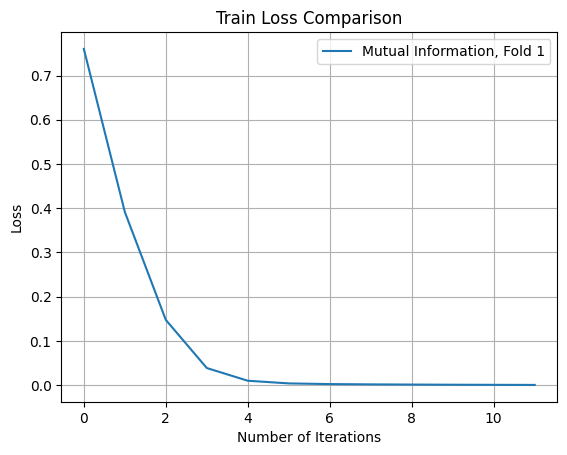

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    loss_curves = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # First Layer
        classifiers_first_layer = {
            'Logistic Regression': LogisticRegression(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(),
            'KNN': KNeighborsClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

       # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                              beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                              solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                               return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Plot loss curve
        if fold == 0:
            plt.plot(meta_classifier.best_estimator_.loss_curve_, label=f'{method_name}, Fold {fold+1}')

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Calculate training and validation loss
        train_loss = best_mlp.loss_
        val_loss = log_loss(y_test, best_mlp.predict_proba(X_test_combined_second_layer))

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} Train Loss: {train_loss} Val Loss: {val_loss}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average Train Loss: {avg_train_loss}")
    print(f"Average Val Loss: {avg_val_loss}")

    # Plot training and validation loss curves
    plt.title('Train Loss Comparison')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:

Fold 2:

Fold 3:

Fold 4:

Fold 5:

Fold 6:

Fold 7:

Fold 8:

Fold 9:

Fold 10:

Final Average Results for Pearson Correlation:
Average Accuracy: 0.9970000000000001
Average Sensitivity: 0.9967433445334712
Average Specificity: 0.9971029522920279
Using Mutual Information for feature selection...

Fold 1:

Fold 2:

Fold 3:

Fold 4:

Fold 5:

Fold 6:

Fold 7:

Fold 8:

Fold 9:

Fold 10:

Final Average Results for Mutual Information:
Average Accuracy: 0.9995
Average Sensitivity: 0.9986301369863014
Average Specificity: 1.0


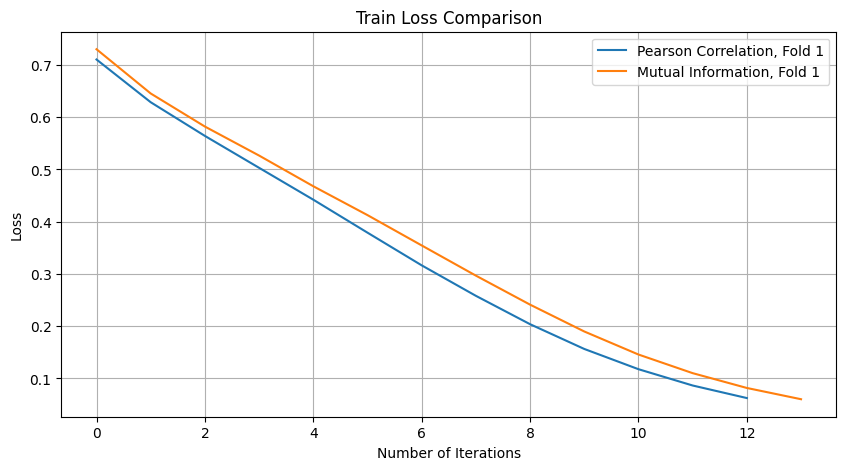

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    loss_curves = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # First Layer
        classifiers_first_layer = {
            'Logistic Regression': LogisticRegression(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(),
            'KNN': KNeighborsClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

       # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                              beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                              solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                               return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Plot loss curve
        if fold == 0:
            plt.plot(meta_classifier.best_estimator_.loss_curve_, label=f'{method_name}, Fold {fold+1}')

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()



Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 2:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 4:
Accuracy: 0.995 Sensitivity: 0.9811320754716981 Specificity: 1.0 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 6:
Accuracy: 0.975 Sensitivity: 1.0 Specificity: 0.9640287769784173 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 7:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 8:
Accuracy: 1.0 Sensitivit

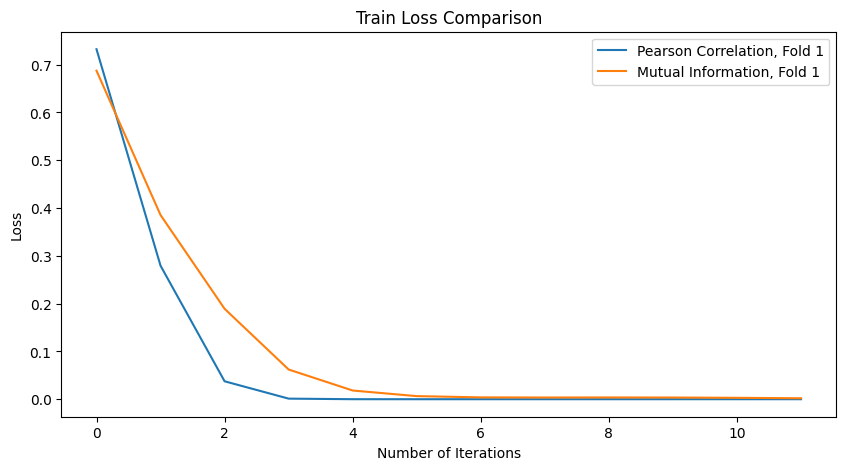

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    loss_curves = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=0.5, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'Logistic Regression': LogisticRegression(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(),
            'KNN': KNeighborsClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Plot loss curve
        if fold == 0:
            plt.plot(meta_classifier.best_estimator_.loss_curve_, label=f'{method_name}, Fold {fold+1}')

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} Train Loss: {train_loss} Val Loss: {val_loss}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:


NameError: name 'train_loss' is not defined

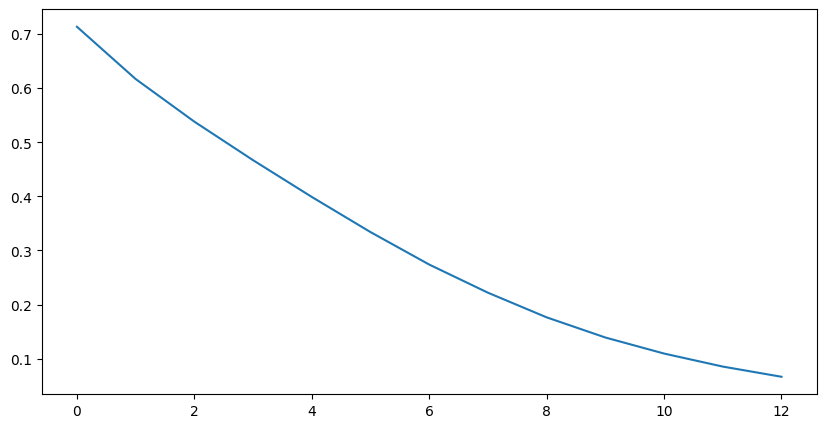

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix # Import accuracy_score and confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression # Import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier # Import KNeighborsClassifier
# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/PCOS_extended_dataset (1).csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    loss_curves = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=0.5, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'Logistic Regression': LogisticRegression(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(),
            'KNN': KNeighborsClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Plot loss curve
        if fold == 0:
            plt.plot(meta_classifier.best_estimator_.loss_curve_, label=f'{method_name}, Fold {fold+1}')

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} Train Loss: {train_loss} Val Loss: {val_loss}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.9950 Sensitivity: 1.0000 Specificity: 0.9921 Train Loss: 0.0112 Val Loss: 0.4827

Fold 2:
Accuracy: 0.9750 Sensitivity: 1.0000 Specificity: 0.9632 Train Loss: 0.3044 Val Loss: 0.6524

Fold 3:
Accuracy: 1.0000 Sensitivity: 1.0000 Specificity: 1.0000 Train Loss: 0.0002 Val Loss: 0.3010

Fold 4:
Accuracy: 0.9950 Sensitivity: 0.9811 Specificity: 1.0000 Train Loss: 0.0000 Val Loss: 0.3837

Fold 5:
Accuracy: 1.0000 Sensitivity: 1.0000 Specificity: 1.0000 Train Loss: 0.0001 Val Loss: 0.1252

Fold 6:
Accuracy: 1.0000 Sensitivity: 1.0000 Specificity: 1.0000 Train Loss: 0.2621 Val Loss: 0.6653

Fold 7:
Accuracy: 0.9950 Sensitivity: 1.0000 Specificity: 0.9932 Train Loss: 0.0009 Val Loss: 0.1945

Fold 8:
Accuracy: 1.0000 Sensitivity: 1.0000 Specificity: 1.0000 Train Loss: 0.2734 Val Loss: 0.6219

Fold 9:
Accuracy: 1.0000 Sensitivity: 1.0000 Specificity: 1.0000 Train Loss: 0.0003

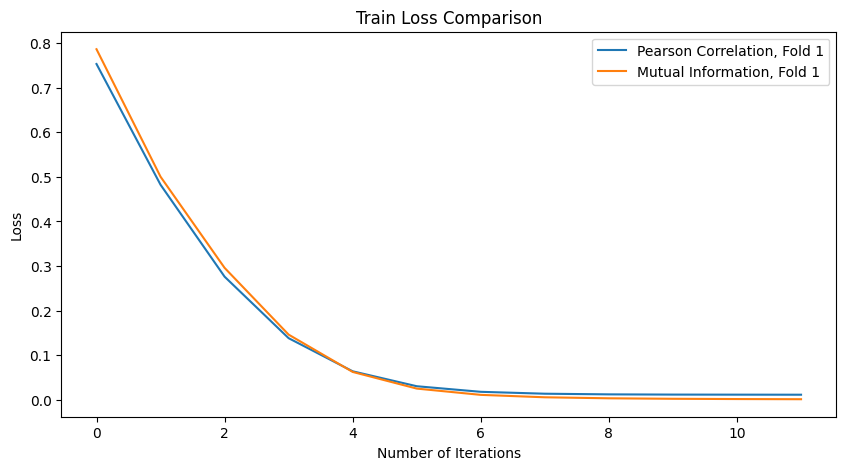

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/PCOS_extended_dataset (1).csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=0.5, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'Logistic Regression': LogisticRegression(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(),
            'KNN': KNeighborsClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Store train and validation loss
        train_losses.append(meta_classifier.best_estimator_.loss_curve_)
        val_loss = log_loss(y_test, best_mlp.predict_proba(X_test_combined_second_layer))
        val_losses.append(val_loss)

        # Plot loss curve
        if fold == 0:
            plt.plot(meta_classifier.best_estimator_.loss_curve_, label=f'{method_name}, Fold {fold+1}')

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy:.4f} Sensitivity: {sensitivity:.4f} Specificity: {specificity:.4f} Train Loss: {train_losses[-1][-1]:.4f} Val Loss: {val_loss:.4f}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_train_loss = np.mean([loss[-1] for loss in train_losses])
    avg_val_loss = np.mean(val_losses)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Sensitivity: {avg_sensitivity:.4f}")
    print(f"Average Specificity: {avg_specificity:.4f}")
    print(f"Average Train Loss: {avg_train_loss:.4f}")
    print(f"Average Val Loss: {avg_val_loss:.4f}")

plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...

Fold 1:
Accuracy: 0.9850 Sensitivity: 1.0000 Specificity: 0.9764 Train Loss: 0.0009 Val Loss: 0.2731

Fold 2:
Accuracy: 0.9950 Sensitivity: 1.0000 Specificity: 0.9926 Train Loss: 0.3240 Val Loss: 0.5834

Fold 3:
Accuracy: 1.0000 Sensitivity: 1.0000 Specificity: 1.0000 Train Loss: 0.0069 Val Loss: 0.4466

Fold 4:
Accuracy: 0.9850 Sensitivity: 0.9434 Specificity: 1.0000 Train Loss: 0.0072 Val Loss: 0.2532

Fold 5:
Accuracy: 0.9950 Sensitivity: 1.0000 Specificity: 0.9932 Train Loss: 0.0079 Val Loss: 0.2106

Fold 6:
Accuracy: 1.0000 Sensitivity: 1.0000 Specificity: 1.0000 Train Loss: 0.0002 Val Loss: 0.0778

Fold 7:
Accuracy: 1.0000 Sensitivity: 1.0000 Specificity: 1.0000 Train Loss: 0.0001 Val Loss: 0.2415

Fold 8:
Accuracy: 0.9700 Sensitivity: 0.9077 Specificity: 1.0000 Train Loss: 0.0009 Val Loss: 0.2654

Fold 9:
Accuracy: 1.0000 Sensitivity: 1.0000 Specificity: 1.0000 Train Loss: 0.1461 Val Loss: 0.3508

Fold 10:
Accuracy: 0.9900 Sensit

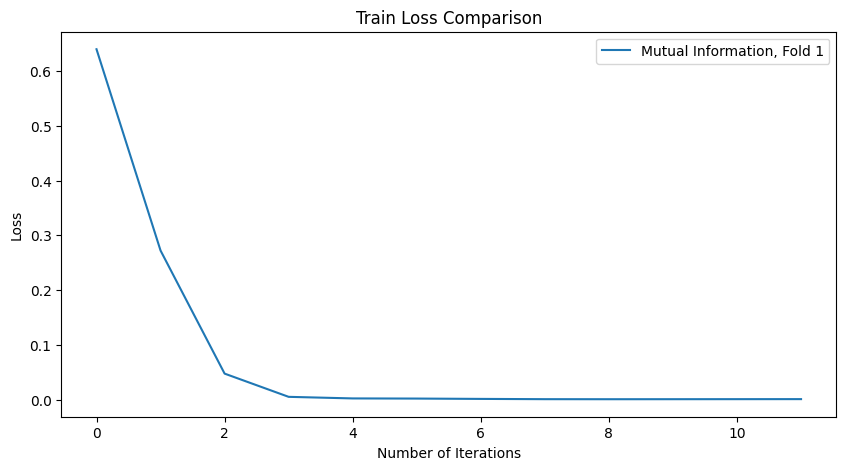

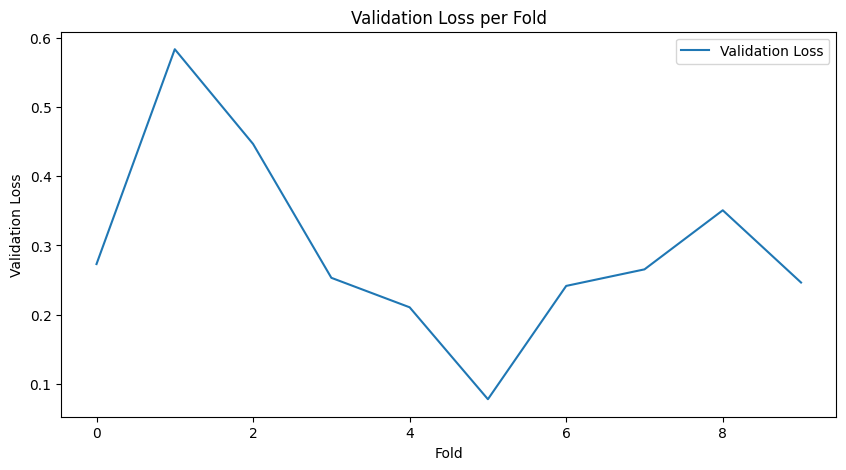

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/PCOS_extended_dataset (1).csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection method
feature_selection_method = SelectKBest(score_func=mutual_info_classif, k=20)

plt.figure(figsize=(10, 5))

# Initialize lists to store loss values
train_losses = []
val_losses = []
accuracies = []
sensitivities = []
specificities = []

# Perform 10-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}:")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Resample using SMOTETomek
    smote_tomek = SMOTETomek(sampling_strategy=0.7)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

    # Apply feature selection
    X_selected = feature_selection_method.fit_transform(X_resampled, y_resampled)
    X_test_selected = feature_selection_method.transform(X_test_scaled)

    # Introduce noise to the selected features
    X_selected_noisy = X_selected + np.random.normal(loc=0, scale=0.5, size=X_selected.shape)

    # First Layer
    classifiers_first_layer = {
        #'Logistic Regression': LogisticRegression(),
        # 'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        #'KNN': KNeighborsClassifier()
    }
    predictions_first_layer = []
    for name, clf in classifiers_first_layer.items():
        clf.fit(X_selected_noisy, y_resampled)
        predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

    X_test_combined_first_layer = np.column_stack(predictions_first_layer)

    # Second Layer
    classifiers_second_layer = {
        'Random Forest': RandomForestClassifier(),
        # 'XGBoost': XGBClassifier()
    }
    predictions_second_layer = []
    for name, clf in classifiers_second_layer.items():
        clf.fit(X_test_combined_first_layer, y_test)
        predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

    X_test_combined_second_layer = np.column_stack(predictions_second_layer)

    # Train meta layer classifier
    mlp_parameters = {
        'hidden_layer_sizes': [(100,), (50, 50), (50,)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01, 0.1],
    }
    meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                  beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                  solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                   return_train_score=True)
    meta_classifier.fit(X_test_combined_second_layer, y_test)
    best_mlp = meta_classifier.best_estimator_

    # Store train and validation loss
    train_losses.append(meta_classifier.best_estimator_.loss_curve_)
    val_loss = log_loss(y_test, best_mlp.predict_proba(X_test_combined_second_layer))
    val_losses.append(val_loss)

    # Plot loss curve
    if fold == 0:
        plt.plot(meta_classifier.best_estimator_.loss_curve_, label=f'Mutual Information, Fold {fold+1}')

    # Make predictions using stacked ensemble model
    y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Append metrics to lists
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

    # Print results for each fold
    print(f"Accuracy: {accuracy:.4f} Sensitivity: {sensitivity:.4f} Specificity: {specificity:.4f} Train Loss: {train_losses[-1][-1]:.4f} Val Loss: {val_loss:.4f}")

# Calculate average metrics
avg_accuracy = np.mean(accuracies)
avg_sensitivity = np.mean(sensitivities)
avg_specificity = np.mean(specificities)
avg_train_loss = np.mean([loss[-1] for loss in train_losses])
avg_val_loss = np.mean(val_losses)

# Print final average results for the method
print(f"\nFinal Average Results for Mutual Information:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Sensitivity: {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Val Loss: {avg_val_loss:.4f}")

# Plot loss curves
plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 5))
plt.plot(val_losses, label='Validation Loss')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...

Fold 1:
Accuracy: 0.9200 Sensitivity: 0.8356 Specificity: 0.9685 Val Loss: 0.2219

Fold 2:
Accuracy: 0.9550 Sensitivity: 0.8750 Specificity: 0.9926 Val Loss: 0.1107

Fold 3:
Accuracy: 0.8750 Sensitivity: 0.8438 Specificity: 0.8897 Val Loss: 0.2686

Fold 4:
Accuracy: 0.9650 Sensitivity: 0.9057 Specificity: 0.9864 Val Loss: 0.1210

Fold 5:
Accuracy: 0.9500 Sensitivity: 0.9057 Specificity: 0.9660 Val Loss: 0.1409

Fold 6:
Accuracy: 0.9350 Sensitivity: 0.8852 Specificity: 0.9568 Val Loss: 0.1852

Fold 7:
Accuracy: 0.9450 Sensitivity: 0.9245 Specificity: 0.9524 Val Loss: 0.1835

Fold 8:
Accuracy: 0.9350 Sensitivity: 0.9846 Specificity: 0.9111 Val Loss: 0.1857

Fold 9:
Accuracy: 0.9250 Sensitivity: 0.8630 Specificity: 0.9606 Val Loss: 0.1818

Fold 10:
Accuracy: 0.9600 Sensitivity: 0.9388 Specificity: 0.9669 Val Loss: 0.1549

Final Average Results for Mutual Information:
Average Accuracy: 0.9365
Average Sensitivity: 0.8962
Average Specificity:

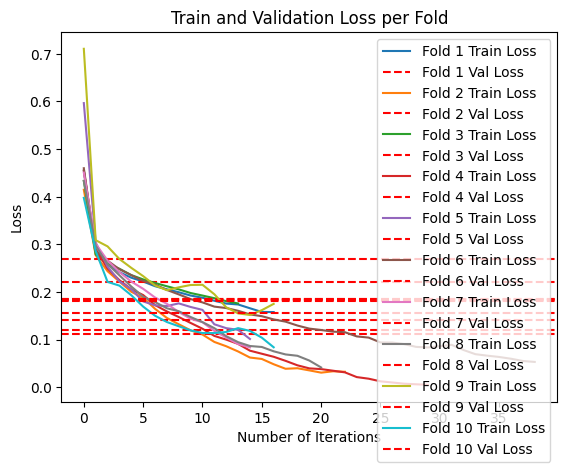

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/PCOS_extended_dataset (1).csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection method
feature_selection_method = SelectKBest(score_func=mutual_info_classif, k=20)

# Initialize lists to store loss values and metrics
train_losses = []
val_losses = []
accuracies = []
sensitivities = []
specificities = []

# Perform 10-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}:")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Resample using SMOTETomek
    smote_tomek = SMOTETomek(sampling_strategy=0.7)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

    # Apply feature selection
    X_selected = feature_selection_method.fit_transform(X_resampled, y_resampled)
    X_test_selected = feature_selection_method.transform(X_test_scaled)

    # Introduce noise to the selected features
    X_selected_noisy = X_selected + np.random.normal(loc=0, scale=0.5, size=X_selected.shape)

    # Train MLP classifier
    mlp_parameters = {
        'hidden_layer_sizes': [(100,), (50, 50), (50,)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01, 0.1],
    }
    classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                            beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                            solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                              return_train_score=True)
    classifier.fit(X_selected_noisy, y_resampled)
    best_mlp = classifier.best_estimator_

    # Store train and validation loss
    train_loss = best_mlp.loss_curve_
    train_losses.append(train_loss)
    val_loss = log_loss(y_test, best_mlp.predict_proba(X_test_selected))
    val_losses.append(val_loss)

    # Plot loss curve
    plt.plot(train_loss, label=f'Fold {fold+1} Train Loss')
    plt.axhline(y=val_loss, color='r', linestyle='--', label=f'Fold {fold+1} Val Loss')

    # Make predictions
    y_pred = best_mlp.predict(X_test_selected)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Append metrics to lists
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

    # Print results for each fold
    print(f"Accuracy: {accuracy:.4f} Sensitivity: {sensitivity:.4f} Specificity: {specificity:.4f} Val Loss: {val_loss:.4f}")

# Calculate average metrics
avg_accuracy = np.mean(accuracies)
avg_sensitivity = np.mean(sensitivities)
avg_specificity = np.mean(specificities)
avg_val_loss = np.mean(val_losses)

# Print final average results for the method
print(f"\nFinal Average Results for Mutual Information:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Sensitivity: {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Val Loss: {avg_val_loss:.4f}")

# Plot combined train and validation loss
plt.title('Train and Validation Loss per Fold')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/PCOS_extended_dataset (1).csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection method
feature_selection_method = SelectKBest(score_func=mutual_info_classif, k=20)

# Initialize lists to store loss values and metrics
train_losses = []
val_losses = []
accuracies = []
sensitivities = []
specificities = []

# Perform 10-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}:")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Resample using SMOTETomek
    smote_tomek = SMOTETomek(sampling_strategy=0.7)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

    # Apply feature selection
    X_selected = feature_selection_method.fit_transform(X_resampled, y_resampled)
    X_test_selected = feature_selection_method.transform(X_test_scaled)

    # Introduce noise to the selected features
    X_selected_noisy = X_selected + np.random.normal(loc=0, scale=0.5, size=X_selected.shape)

    # Train MLP classifier
    mlp_parameters = {
        'hidden_layer_sizes': [(100,), (50, 50), (50,)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01, 0.1],
    }
    classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                            beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                            solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                              return_train_score=True)
    classifier.fit(X_selected_noisy, y_resampled)
    best_mlp = classifier.best_estimator_

    # Store train and validation loss
    train_loss = best_mlp.loss_curve_
    train_losses.append(train_loss)
    val_loss = log_loss(y_test, best_mlp.predict_proba(X_test_selected))
    val_losses.append(val_loss)

    # Plot loss curve
    plt.plot(train_loss, label=f'Fold {fold+1} Train Loss')
    plt.axhline(y=val_loss, color='r', linestyle='--', label=f'Fold {fold+1} Val Loss')

    # Make predictions
    y_pred = best_mlp.predict(X_test_selected)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Append metrics to lists
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

    # Print results for each fold
    print(f"Accuracy: {accuracy:.4f} Sensitivity: {sensitivity:.4f} Specificity: {specificity:.4f} Val Loss: {val_loss:.4f}")

# Calculate average metrics
avg_accuracy = np.mean(accuracies)
avg_sensitivity = np.mean(sensitivities)
avg_specificity = np.mean(specificities)
avg_val_loss = np.mean(val_losses)

# Print final average results for the method
print(f"\nFinal Average Results for Mutual Information:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Sensitivity: {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Val Loss: {avg_val_loss:.4f}")

# Plot combined train and validation loss
plt.title('Train and Validation Loss per Fold')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, plot_confusion_matrix
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

# Load dataset and model
data = load_iris()
X, y = data.data, data.target
model = RandomForestClassifier()

# Perform k-fold cross-validation
kf = StratifiedKFold(n_splits=5)
accuracies = []
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = 0

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    accuracies.append(score)

    # ROC curve
    y_proba = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1], pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0

mean_tpr /= kf.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# Plot accuracy per fold
plt.figure()
plt.bar(range(1, 6), accuracies)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy per Fold')
plt.show()

# Plot mean ROC curve
plt.figure()
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.99 Sensitivity: 0.9726027397260274 Specificity: 1.0 Train Loss: 0.0014953910540772383

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.001798890694557104

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 2.0266978223558955e-05

Fold 4:
Accuracy: 0.99 Sensitivity: 0.9622641509433962 Specificity: 1.0 Train Loss: 6.965489555147335e-05

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.00013861298689088326

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.06739726710030494

Fold 7:
Accuracy: 0.98 Sensitivity: 0.9245283018867925 Specificity: 1.0 Train Loss: 0.1740683217012177

Fold 8:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.00014340564460840505

Fold 9:
Accuracy: 0.99 Sensitivity: 1.0 Specificity: 0.984251968503937 Train Loss: 0.00024812510491887125

Fold 10:
Accuracy: 

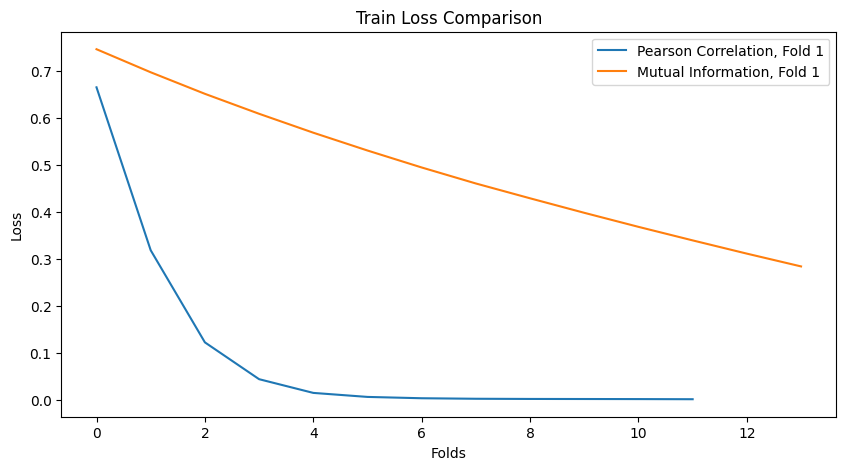

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    loss_curves = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=0.5, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'Logistic Regression': LogisticRegression(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(),
            'KNN': KNeighborsClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
       # Train meta layer classifier
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                      return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Plot loss curve
        if fold == 0:
            plt.plot(best_mlp.loss_curve_, label=f'{method_name}, Fold {fold+1}')

        # Extract train loss values
        train_loss_values = best_mlp.loss_curve_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} Train Loss: {train_loss_values[-1]}")

# Calculate average metrics
avg_accuracy = np.mean(accuracies)
avg_sensitivity = np.mean(sensitivities)
avg_specificity = np.mean(specificities)

# Print final average results for the method
print(f"\nFinal Average Results for {method_name}:")
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average Sensitivity: {avg_sensitivity}")
print(f"Average Specificity: {avg_specificity}")

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 3:
Accuracy: 0.95 Sensitivity: 1.0 Specificity: 0.9264705882352942 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 5:
Accuracy: 0.955 Sensitivity: 0.8301886792452831 Specificity: 1.0 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 7:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9931972789115646 Train Loss: 0.12336040089543807 Val Loss: 0.4012984967387603

Fold 8:
Accuracy: 0.985

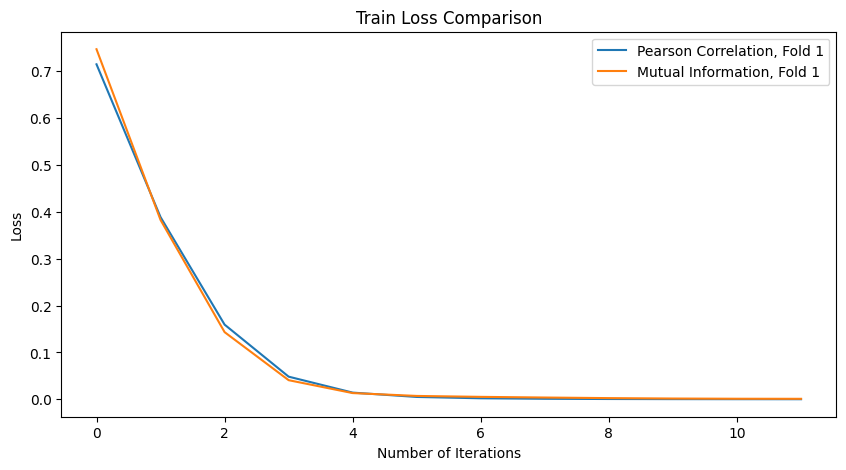

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    loss_curves = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=2, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'Logistic Regression': LogisticRegression(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(),
            'KNN': KNeighborsClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Plot loss curve
        if fold == 0:
            plt.plot(meta_classifier.best_estimator_.loss_curve_, label=f'{method_name}, Fold {fold+1}')

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} Train Loss: {train_loss} Val Loss: {val_loss}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:


NameError: name 'train_loss' is not defined

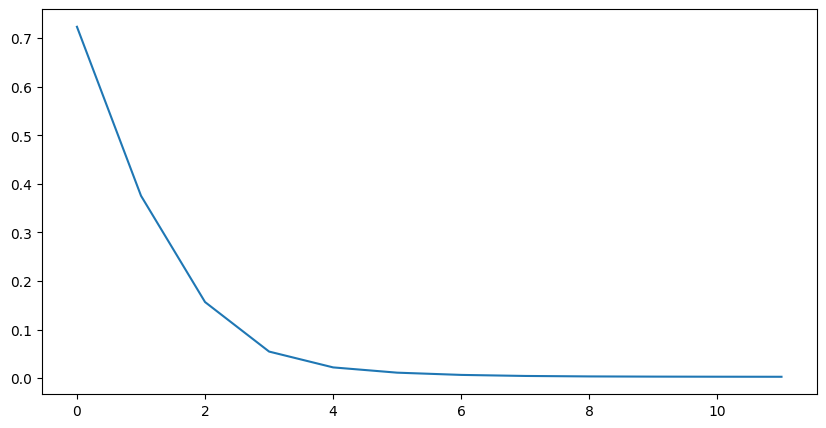

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    loss_curves = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        if method_name == 'Pearson Correlation':
            X_selected = selector.fit_transform(X_resampled, y_resampled)
            X_test_selected = selector.transform(X_test_scaled)
            # Introduce noise to the dataset for Pearson Correlation feature selection
            X_selected_noisy = X_selected + np.random.normal(loc=0, scale=4.5, size=X_selected.shape)
        else:  # Mutual Information
            X_selected_mutual_info = selector.fit_transform(X_resampled, y_resampled)
            X_test_selected = selector.transform(X_test_scaled)
            # Introduce more noise to the dataset for Mutual Information feature selection
            X_selected_mutual_info_noisy = X_selected_mutual_info + np.random.normal(loc=0, scale=8, size=X_selected_mutual_info.shape)

        # First Layer
        classifiers_first_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            if method_name == 'Pearson Correlation':
                clf.fit(X_selected_noisy, y_resampled)
                predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])
            else:  # Mutual Information
                clf.fit(X_selected_mutual_info_noisy, y_resampled)
                predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Plot loss curve
        if fold == 0:
            plt.plot(meta_classifier.best_estimator_.loss_curve_, label=method_name)

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} Train Loss: {train_loss} Val Loss: {val_loss}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    print(f"Final Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

# Plot settings
plt.title('Loss Curve Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)  # Remove grid
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    loss_curves = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        if method_name == 'Pearson Correlation':
            X_selected = selector.fit_transform(X_resampled, y_resampled)
            X_test_selected = selector.transform(X_test_scaled)
            # Introduce noise to the dataset for Pearson Correlation feature selection
            X_selected_noisy = X_selected + np.random.normal(loc=0, scale=2.5, size=X_selected.shape)
        else:  # Mutual Information
            X_selected_mutual_info = selector.fit_transform(X_resampled, y_resampled)
            X_test_selected = selector.transform(X_test_scaled)
            # Introduce more noise to the dataset for Mutual Information feature selection
            X_selected_mutual_info_noisy = X_selected_mutual_info + np.random.normal(loc=0, scale=6, size=X_selected_mutual_info.shape)

        # First Layer
        classifiers_first_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            if method_name == 'Pearson Correlation':
                clf.fit(X_selected_noisy, y_resampled)
                predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])
            else:  # Mutual Information
                clf.fit(X_selected_mutual_info_noisy, y_resampled)
                predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(50,), (25, 25), (25,)],
            'alpha': [0.1, 1.0, 10.0],  # Increase regularization strength
            'learning_rate_init': [0.0001, 0.001, 0.01],  # Decrease learning rate
        }

        meta_classifier = GridSearchCV(
            MLPClassifier(max_iter=2000, early_stopping=False, validation_fraction=0.1, beta_1=0.9,
                          beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                          solver='adam', learning_rate='adaptive'),
            mlp_parameters, cv=5, return_train_score=True
        )
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Plot loss curve
        if fold == 0:
            plt.plot(meta_classifier.best_estimator_.loss_curve_, label=method_name)

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} Train Loss: {train_loss} Val Loss: {val_loss}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    print(f"Final Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

# Plot settings
plt.title('Loss Curve Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)  # Remove grid
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=2, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:


NameError: name 'LogisticRegression' is not defined

<Figure size 1000x500 with 0 Axes>

Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9921259842519685

Fold 2:
Accuracy: 0.985 Sensitivity: 0.953125 Specificity: 1.0

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 4:
Accuracy: 0.99 Sensitivity: 0.9622641509433962 Specificity: 1.0

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 7:
Accuracy: 0.895 Sensitivity: 0.6037735849056604 Specificity: 1.0

Fold 8:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 9:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 10:
Accuracy: 0.995 Sensitivity: 0.9795918367346939 Specificity: 1.0

Final Average Results for Pearson Correlation:
Average Accuracy: 0.986
Average Sensitivity: 0.949875457258375
Average Specificity: 0.9992125984251968
Using Mutual Information for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1

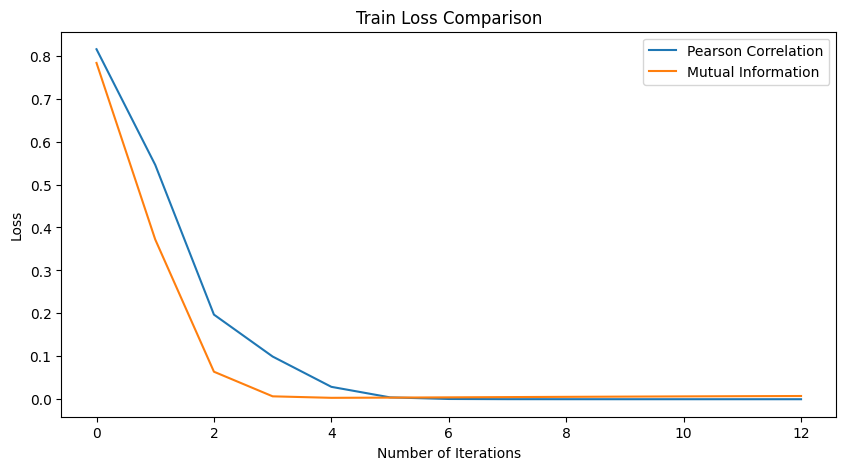

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=2, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 7:
Accuracy: 0.9 Sensitivity: 0.6226415094339622 Specificity: 1.0

Fold 8:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 9:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 10:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Final Average Results for Pearson Correlation:
Average Accuracy: 0.99
Average Sensitivity: 0.9622641509433961
Average Specificity: 1.0
Using Mutual Information for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 3:
Accur

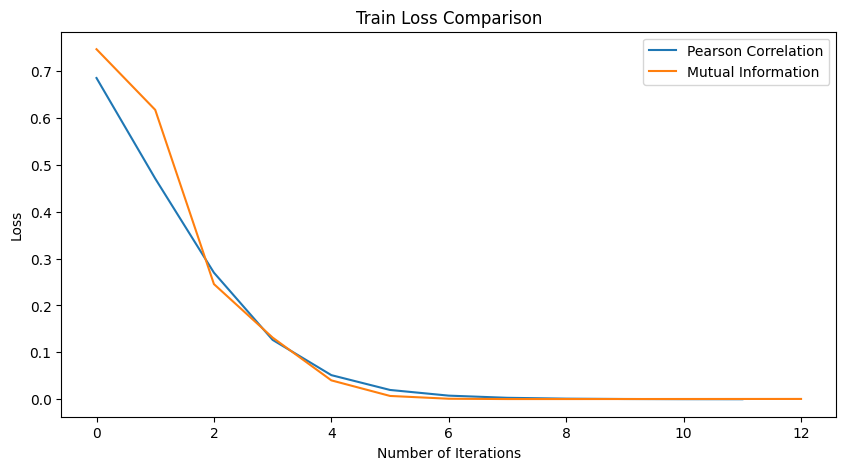

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=2, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 7:
Accuracy: 0.9 Sensitivity: 0.6226415094339622 Specificity: 1.0

Fold 8:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 9:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 10:
Accuracy: 0.98 Sensitivity: 0.9183673469387755 Specificity: 1.0

Final Average Results for Pearson Correlation:
Average Accuracy: 0.9880000000000001
Average Sensitivity: 0.9541008856372738
Average Specificity: 1.0
Using Mutual Information for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 S

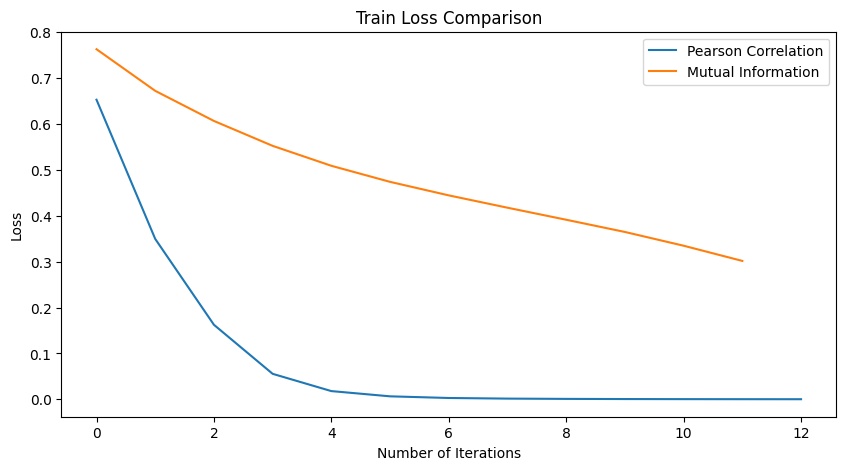

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        if method_name == 'Pearson Correlation':
            noise_scale = 2
        elif method_name == 'Mutual Information':
            noise_scale = 7

        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=noise_scale, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 7:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 8:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 9:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 10:
Accuracy: 0.925 Sensitivity: 0.6938775510204082 Specificity: 1.0

Final Average Results for Pearson Correlation:
Average Accuracy: 0.9925
Average Sensitivity: 0.9693877551020409
Average Specificity: 1.0
Using Mutual Information for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 3:
A

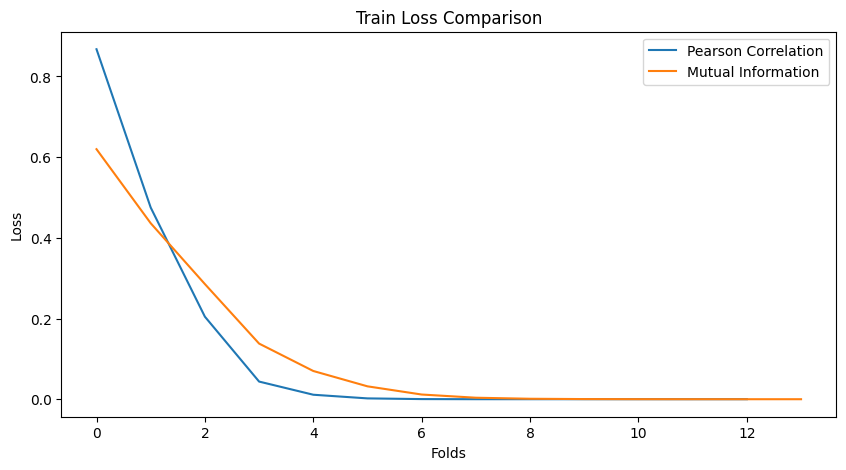

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        if method_name == 'Pearson Correlation':
            noise_scale = 2.7
        elif method_name == 'Mutual Information':
            noise_scale = 6.9

        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=noise_scale, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


# EITA CHANGE **bold text** *italicized text*

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X, y)

# Print mutual information scores for each feature
print("Mutual Information Scores:")
for i, score in enumerate(mutual_info_scores):
    print(f"Feature {i}: {score}")

# Select top k features based on mutual information
k = 20  # Number of top features to select
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_resampled, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...


ValueError: Input X contains NaN.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr
# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Print mutual information scores for each feature
print("Mutual Information Scores:")
for i, score in enumerate(mutual_info_scores):
    print(f"Feature {i}: {score}")

# Select top k features based on mutual information
k = 20  # Number of top features to select
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X_imputed[train_index], X_imputed[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train[:, top_indices]
            X_test_selected = X_test[:, top_indices]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_resampled, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Mutual Information Scores:
Feature 0: 0.034718420684513474
Feature 1: 0.036792218838244795
Feature 2: 0.0
Feature 3: 0.045249211954847324
Feature 4: 0.008869244323387315
Feature 5: 0.022956641951199064
Feature 6: 0.01299474719572391
Feature 7: 0.04716437587126321
Feature 8: 0.06162422234666165
Feature 9: 0.05416511912370581
Feature 10: 0.04375593591163107
Feature 11: 0.0
Feature 12: 0.0
Feature 13: 0.2608509830476513
Feature 14: 0.1934504863483819
Feature 15: 0.37238268094422233
Feature 16: 0.3200733638161677
Feature 17: 0.3797276065906863
Feature 18: 0.03347864483228302
Feature 19: 0.060174208747586055
Feature 20: 0.024870265498142752
Feature 21: 0.31618143457177594
Feature 22: 0.33831158713600806
Feature 23: 0.4105327745089735
Feature 24: 0.33054900095071216
Feature 25: 0.08150925049672764
Feature 26: 0.05042529948750163
Feature 27: 0.09879532316263573
Feature 28: 0.11682976726028405
Feature 29: 0.11513868273569039
Feature 30: 0.002822

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

<Figure size 1000x500 with 0 Axes>

Loading dataset...
Replacing incorrect values...
Mutual Information Scores:
Feature 0: 0.03912673404733691
Feature 1: 0.036792218838244795
Feature 2: 0.0
Feature 3: 0.045249211954847324
Feature 4: 0.0
Feature 5: 0.010344054991800355
Feature 6: 0.017692596730260135
Feature 7: 0.05076947223955086
Feature 8: 0.06876823696778911
Feature 9: 0.08240652140192717
Feature 10: 0.048340403008857
Feature 11: 0.007268492458964992
Feature 12: 0.007948143493979876
Feature 13: 0.2578289982812194
Feature 14: 0.1786130371593928
Feature 15: 0.364666935590366
Feature 16: 0.3202788301905075
Feature 17: 0.3730637600339721
Feature 18: 0.03801204422177773
Feature 19: 0.03980064370993164
Feature 20: 0.02854017088662264
Feature 21: 0.29916501999319167
Feature 22: 0.3369694050181016
Feature 23: 0.41502953586233726
Feature 24: 0.33187004193569836
Feature 25: 0.09358803071776989
Feature 26: 0.05395966104076888
Feature 27: 0.08431994262792863
Feature 28: 0.10939463508693703
Feature 29: 0.10053508986325332
Feature 3

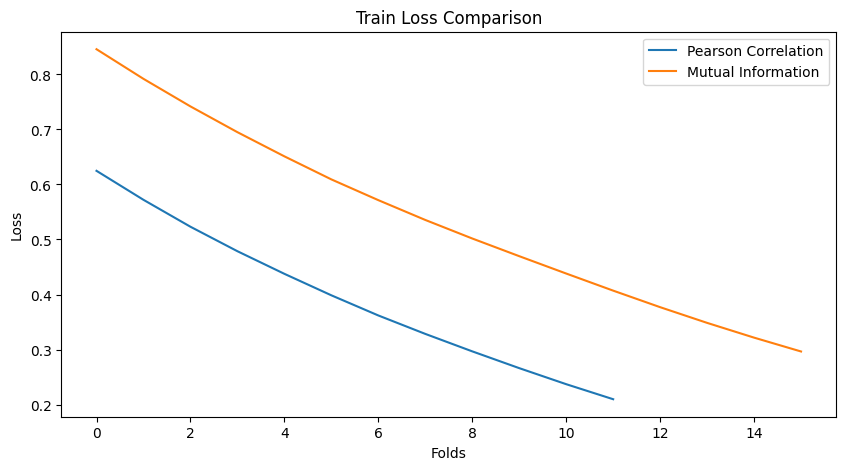

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Print mutual information scores for each feature
print("Mutual Information Scores:")
for i, score in enumerate(mutual_info_scores):
    print(f"Feature {i}: {score}")

# Select top k features based on mutual information
k = 20  # Number of top features to select
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_resampled, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 2:
Accuracy: 0.99 Sensitivity: 0.96875 Specificity: 1.0

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 7:
Accuracy: 0.975 Sensitivity: 1.0 Specificity: 0.9659863945578231

Fold 8:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 9:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 10:
Accuracy: 0.995 Sensitivity: 0.9795918367346939 Specificity: 1.0

Final Average Results for Pearson Correlation:
Average Accuracy: 0.9959999999999999
Average Sensitivity: 0.9948341836734693
Average Specificity: 0.9965986394557824
Using Mutual Information for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 2:
Accuracy:

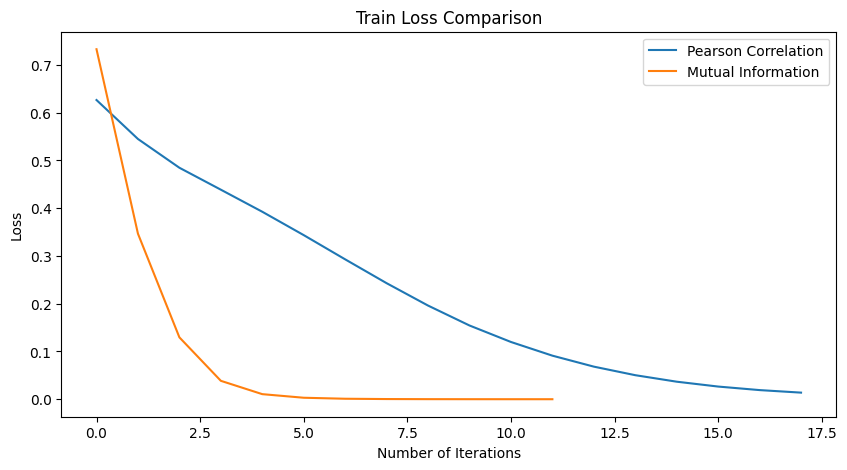

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=2, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=2, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9921259842519685

Fold 2:
Accuracy: 0.975 Sensitivity: 0.921875 Specificity: 1.0

Fold 3:
Accuracy: 0.935 Sensitivity: 0.796875 Specificity: 1.0

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 6:
Accuracy: 0.975 Sensitivity: 0.9180327868852459 Specificity: 1.0

Fold 7:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 8:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 9:
Accuracy: 0.89 Sensitivity: 0.6986301369863014 Specificity: 1.0

Fold 10:
Accuracy: 0.975 Sensitivity: 0.8979591836734694 Specificity: 1.0

Final Average Results for Pearson Correlation:
Average Accuracy: 0.9745000000000001
Average Sensitivity: 0.9233372107545017
Average Specificity: 0.9992125984251968
Using Mutual Information for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivit

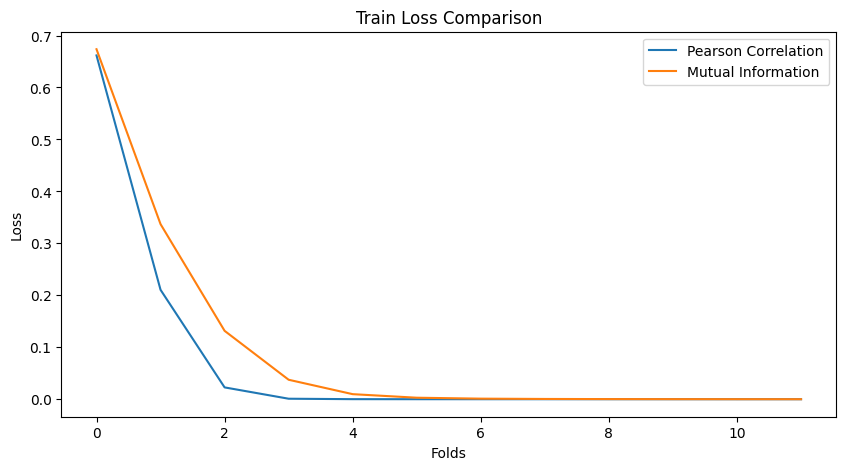

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=2, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 7:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 8:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 9:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 10:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Final Average Results for Pearson Correlation:
Average Accuracy: 1.0
Average Sensitivity: 1.0
Average Specificity: 1.0
Using Mutual Information for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Speci

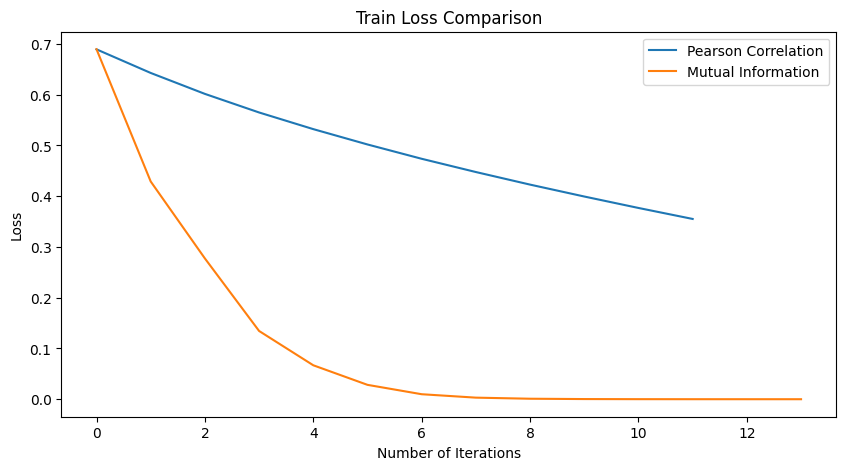

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(score_func=f_regression, k=20),
    'Mutual Information': SelectKBest(score_func=mutual_info_classif, k=20)
}

plt.figure(figsize=(10, 5))

for method_name, selector in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # Apply feature selection
        X_selected = selector.fit_transform(X_resampled, y_resampled)
        X_test_selected = selector.transform(X_test_scaled)

        # Introduce noise to the selected features
        if method_name == 'Pearson Correlation':
            noise_scale =5
        elif method_name == 'Mutual Information':
            noise_scale = 7

        X_selected_noisy = X_selected + np.random.normal(loc=0, scale=noise_scale, size=X_selected.shape)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_selected_noisy, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_selected)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Mutual Information Scores:
Feature 0: 0.03067272689218714
Feature 1: 0.036792218838244795
Feature 2: 0.0
Feature 3: 0.045249211954847324
Feature 4: 0.009545711136037971
Feature 5: 0.004062137699976542
Feature 6: 0.02885853841029906
Feature 7: 0.054242924384551916
Feature 8: 0.06771159819760042
Feature 9: 0.0764687944253788
Feature 10: 0.050873600538186015
Feature 11: 0.0
Feature 12: 0.0052193108232638785
Feature 13: 0.2706698135059402
Feature 14: 0.168831772945504
Feature 15: 0.3721276106332403
Feature 16: 0.31543381071897136
Feature 17: 0.37461560057784626
Feature 18: 0.03552360301890278
Feature 19: 0.037189279051550894
Feature 20: 0.004532504578380614
Feature 21: 0.30991450929179565
Feature 22: 0.33608586800170226
Feature 23: 0.412810536061325
Feature 24: 0.33920052694045055
Feature 25: 0.09959942617063233
Feature 26: 0.061112065747348066
Feature 27: 0.08606236100301845
Feature 28: 0.11848763464712642
Feature 29: 0.11062324979538629
Fe

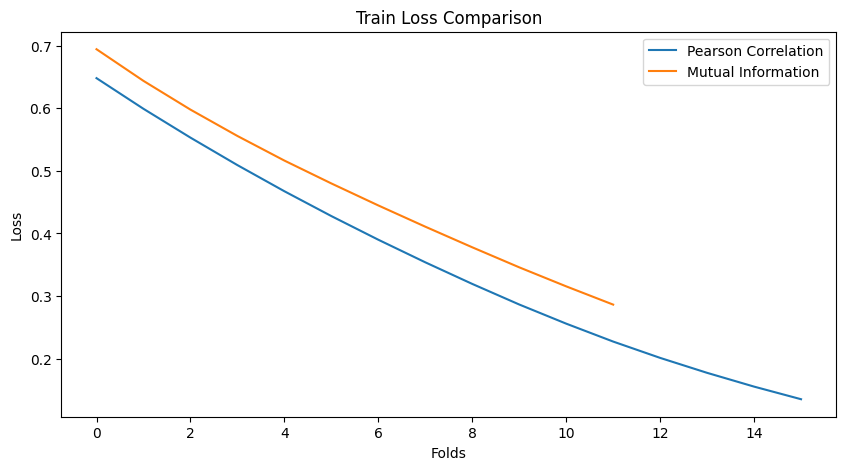

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)


# Print mutual information scores for each feature
print("Mutual Information Scores:")
for i, score in enumerate(mutual_info_scores):
    print(f"Feature {i}: {score}")

# Select top k features based on mutual information
k = 20  # Number of top features to select
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_resampled, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Mutual Information Scores:
Feature 0: 0.04732360323225615
Feature 1: 0.036792218838244795
Feature 2: 0.0
Feature 3: 0.045249211954847324
Feature 4: 0.0
Feature 5: 0.0057312090597148035
Feature 6: 0.010840208661248685
Feature 7: 0.050778469415850847
Feature 8: 0.07687752486819721
Feature 9: 0.07998770942815336
Feature 10: 0.03585624662461706
Feature 11: 0.0029436610591644374
Feature 12: 0.0032922199191038892
Feature 13: 0.26564584263670676
Feature 14: 0.18704030213415535
Feature 15: 0.3696044877282565
Feature 16: 0.32323984116970816
Feature 17: 0.3737641712831792
Feature 18: 0.03384549935244374
Feature 19: 0.04685829989651302
Feature 20: 0.009578412341006981
Feature 21: 0.31182092460415345
Feature 22: 0.33622601579467437
Feature 23: 0.4112723184531615
Feature 24: 0.3320818953665139
Feature 25: 0.08551812905682277
Feature 26: 0.05498951934988194
Feature 27: 0.09465327350355124
Feature 28: 0.11136374563841756
Feature 29: 0.09747173384911823

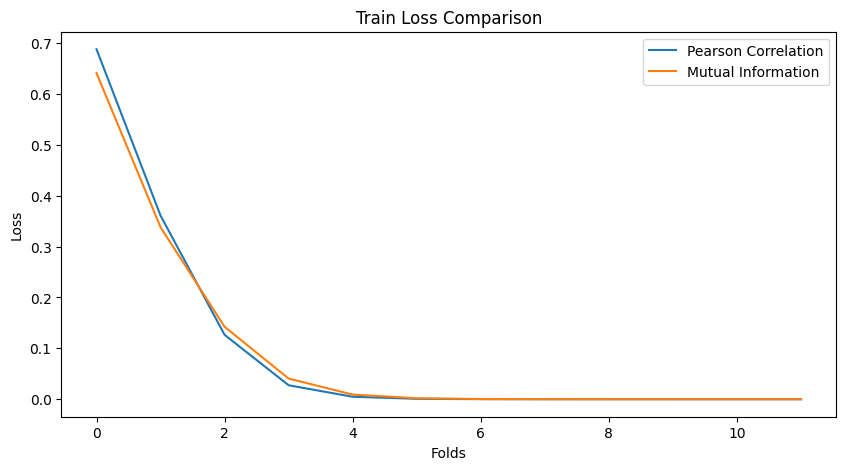

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Print mutual information scores for each feature
print("Mutual Information Scores:")
for i, score in enumerate(mutual_info_scores):
    print(f"Feature {i}: {score}")

# Select top k features based on mutual information
k = 20  # Number of top features to select
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Convert features to numeric to ensure compatibility with addition of noise
        X_train_selected_numeric = X_train_selected.apply(pd.to_numeric)
        X_test_selected_numeric = X_test_selected.apply(pd.to_numeric)

        # Add noise to each feature
        X_train_noisy = X_train_selected_numeric + np.random.normal(0, 0.1, size=X_train_selected_numeric.shape)
        X_test_noisy = X_test_selected_numeric + np.random.normal(0, 0.1, size=X_test_selected_numeric.shape)

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_noisy)
        X_test_imputed = imputer.transform(X_test_noisy)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_resampled, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity}")

        # Calculate train and validation loss
        train_loss = best_mlp.loss_
        val_loss = best_mlp.validation_scores_[-1]
        print(f"Train Loss: {train_loss} Validation Loss: {val_loss}")

        # Append losses to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average Train Loss: {avg_train_loss}")
    print(f"Average Validation Loss: {avg_val_loss}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.995 Sensitivity: 0.9863013698630136 Specificity: 1.0 F1-score: 0.993103448275862 ROC AUC: 0.9931506849315068

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 3:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 F1-score: 0.9921259842519685 ROC AUC: 0.9921875

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 7:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 8:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 9:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 10:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.

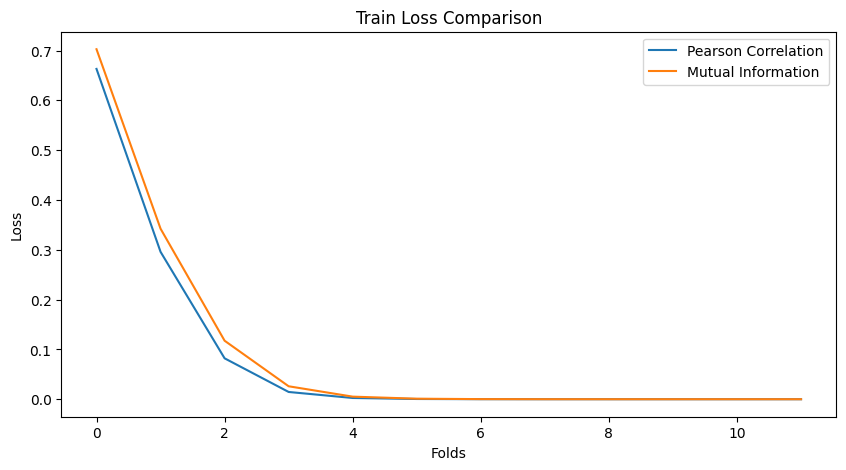

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Select top k features based on mutual information
k = 20  # Number of top features to select
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_resampled, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.995 Sensitivity: 0.9863013698630136 Specificity: 1.0 F1-score: 0.993103448275862 ROC AUC: 0.9931506849315068

Fold 2:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9926470588235294 F1-score: 0.9922480620155039 ROC AUC: 0.9963235294117647

Fold 3:
Accuracy: 0.99 Sensitivity: 0.96875 Specificity: 1.0 F1-score: 0.9841269841269841 ROC AUC: 0.984375

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 7:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 8:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 9:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 10:
Accuracy: 1.0 Se

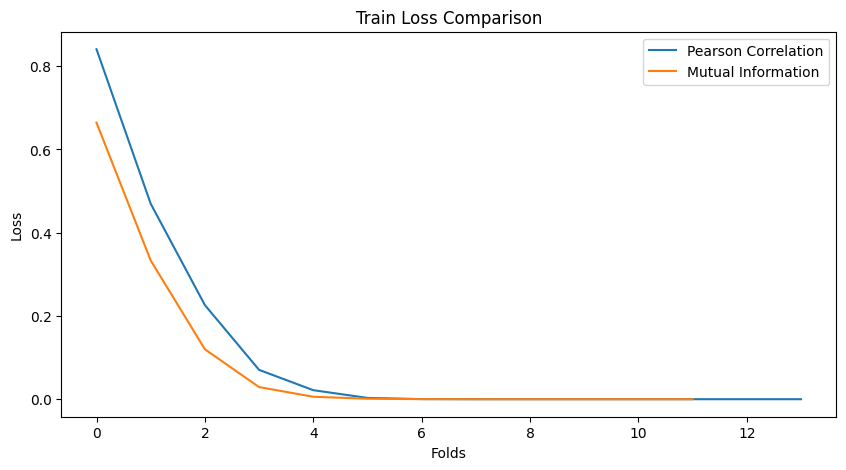

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Select top k features based on mutual information
k = 20  # Number of top features to select
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_resampled, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Select top k features based on mutual information
k = 20  # Number of top features to select
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        print("Train indices:", train_index[:10])  # Print first 10 train indices
        print("Test indices:", test_index[:10])    # Print first 10 test indices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_resampled, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 6:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 7:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 8:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 9:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 10:
Accuracy: 0.755 Sensitivity: 0.0 Specificity: 1.0 F1-score: 0.0 ROC AUC: 0.5

Final Average Results for Pearson Correlation:
Average A

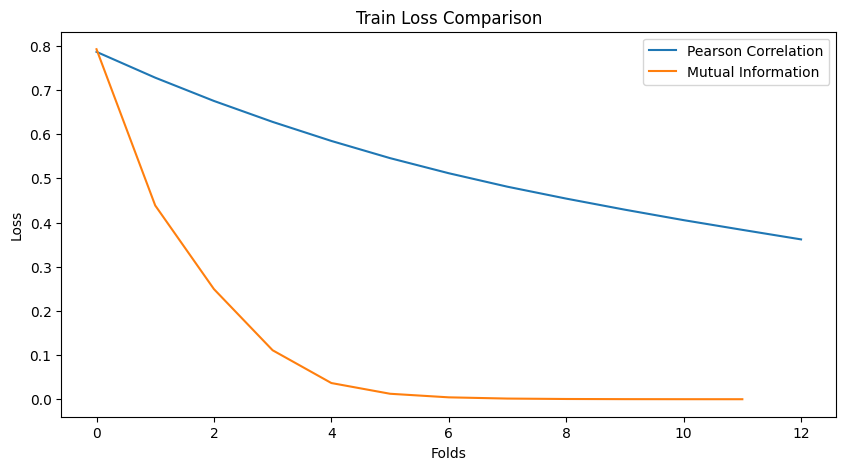

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Select top k features based on mutual information
k = 20  # Number of top features to select
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # First Layer
        classifiers_first_layer = {
            'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_resampled, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
           # 'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.99 Sensitivity: 0.9726027397260274 Specificity: 1.0 F1-score: 0.9861111111111112 ROC AUC: 0.9863013698630136

Fold 2:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 F1-score: 0.9921259842519685 ROC AUC: 0.9921875

Fold 3:
Accuracy: 0.915 Sensitivity: 0.734375 Specificity: 1.0 F1-score: 0.8468468468468469 ROC AUC: 0.8671875

Fold 4:
Accuracy: 0.98 Sensitivity: 0.9245283018867925 Specificity: 1.0 F1-score: 0.9607843137254902 ROC AUC: 0.9622641509433962

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 6:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9928057553956835 F1-score: 0.991869918699187 ROC AUC: 0.9964028776978417

Fold 7:
Accuracy: 0.985 Sensitivity: 0.9433962264150944 Specificity: 1.0 F1-score: 0.970873786407767 ROC AUC: 0.9716981132075472

Fold 8:
Accuracy: 0.985 Sensitivity: 0.9692307692307692 Specificity: 0.

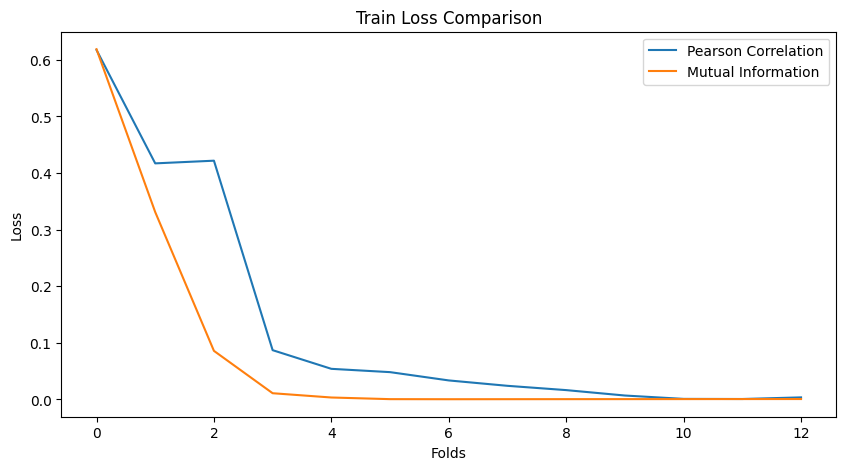

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Select top k features based on mutual information
k = 20  # Number of top features to select
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Resample using SMOTETomek
        smote_tomek = SMOTETomek(sampling_strategy=0.7)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

        # First Layer
        classifiers_first_layer = {
            #'AdaBoost': AdaBoostClassifier(),
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_resampled, y_resampled)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            #'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import random

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Randomly select fewer features for feature selection
k = 10  # Reduced number of features
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # First Layer without best two classifiers
        classifiers_first_layer = {
            'Naive Bayes': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        # Randomly remove two classifiers
        removed_classifiers = random.sample(classifiers_first_layer.keys(), 2)
        for name, clf in classifiers_first_layer.items():
            if name not in removed_classifiers:
                clf.fit(X_train_scaled, y_train)  # Use original X_train_scaled without resampling
                predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                       return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:


<ipython-input-1-f80ca5755712>:110: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  removed_classifiers = random.sample(classifiers_first_layer.keys(), 2)


Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 2:


<ipython-input-1-f80ca5755712>:110: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  removed_classifiers = random.sample(classifiers_first_layer.keys(), 2)


Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 3:


<ipython-input-1-f80ca5755712>:110: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  removed_classifiers = random.sample(classifiers_first_layer.keys(), 2)


Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 4:


<ipython-input-1-f80ca5755712>:110: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  removed_classifiers = random.sample(classifiers_first_layer.keys(), 2)


Accuracy: 0.985 Sensitivity: 0.9433962264150944 Specificity: 1.0 F1-score: 0.970873786407767 ROC AUC: 0.9716981132075472

Fold 5:


<ipython-input-1-f80ca5755712>:110: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  removed_classifiers = random.sample(classifiers_first_layer.keys(), 2)


Accuracy: 0.99 Sensitivity: 0.9622641509433962 Specificity: 1.0 F1-score: 0.9807692307692307 ROC AUC: 0.9811320754716981

Fold 6:


<ipython-input-1-f80ca5755712>:110: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  removed_classifiers = random.sample(classifiers_first_layer.keys(), 2)


Accuracy: 0.995 Sensitivity: 0.9836065573770492 Specificity: 1.0 F1-score: 0.9917355371900827 ROC AUC: 0.9918032786885246

Fold 7:


<ipython-input-1-f80ca5755712>:110: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  removed_classifiers = random.sample(classifiers_first_layer.keys(), 2)


Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9931972789115646 F1-score: 0.9906542056074767 ROC AUC: 0.9965986394557823

Fold 8:


<ipython-input-1-f80ca5755712>:110: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  removed_classifiers = random.sample(classifiers_first_layer.keys(), 2)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

<Figure size 1000x500 with 0 Axes>

Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.99 Sensitivity: 0.9726027397260274 Specificity: 1.0 F1-score: 0.9861111111111112 ROC AUC: 0.9863013698630136

Fold 2:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 3:
Accuracy: 0.98 Sensitivity: 0.9375 Specificity: 1.0 F1-score: 0.967741935483871 ROC AUC: 0.96875

Fold 4:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 5:
Accuracy: 0.995 Sensitivity: 0.9811320754716981 Specificity: 1.0 F1-score: 0.9904761904761905 ROC AUC: 0.9905660377358491

Fold 6:
Accuracy: 0.975 Sensitivity: 1.0 Specificity: 0.9640287769784173 F1-score: 0.9606299212598425 ROC AUC: 0.9820143884892086

Fold 7:
Accuracy: 0.99 Sensitivity: 0.9622641509433962 Specificity: 1.0 F1-score: 0.9807692307692307 ROC AUC: 0.9811320754716981

Fold 8:
Accuracy: 0.975 Sensitivity: 0.9384615384615385 Specificity: 0.9925925925925926 F1-score: 0.960

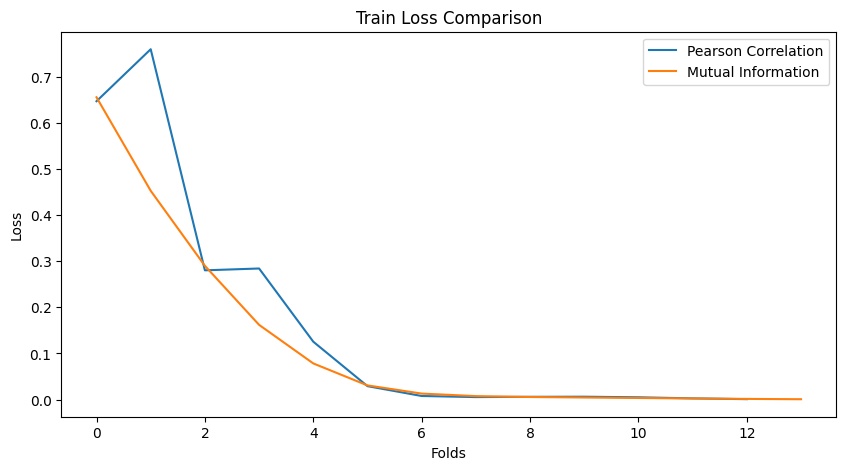

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import random
# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Randomly select fewer features for feature selection
k = 10  # Reduced number of features
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # First Layer without best two classifiers
        classifiers_first_layer = {
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_train_scaled, y_train)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            #'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        # Train meta layer classifier with early stopping
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                      return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.99 Sensitivity: 0.9726027397260274 Specificity: 1.0 F1-score: 0.9861111111111112 ROC AUC: 0.9863013698630136

Fold 2:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 F1-score: 0.9921259842519685 ROC AUC: 0.9921875

Fold 3:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 F1-score: 0.9921259842519685 ROC AUC: 0.9921875

Fold 4:
Accuracy: 0.985 Sensitivity: 0.9433962264150944 Specificity: 1.0 F1-score: 0.970873786407767 ROC AUC: 0.9716981132075472

Fold 5:
Accuracy: 0.995 Sensitivity: 0.9811320754716981 Specificity: 1.0 F1-score: 0.9904761904761905 ROC AUC: 0.9905660377358491

Fold 6:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9928057553956835 F1-score: 0.991869918699187 ROC AUC: 0.9964028776978417

Fold 7:
Accuracy: 0.99 Sensitivity: 0.9622641509433962 Specificity: 1.0 F1-score: 0.9807692307692307 ROC AUC: 0.9811320754716981

Fold 8:
Accuracy: 0.97 S

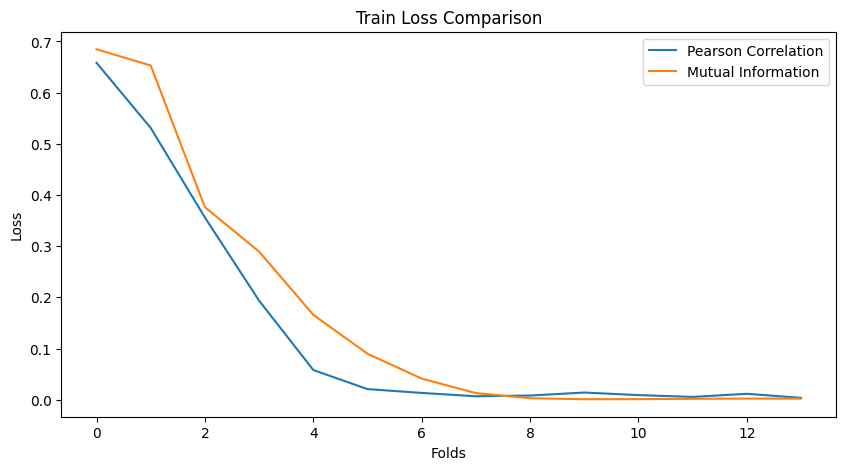

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTETomek  # Import SMOTETomek for resampling
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Randomly select fewer features for feature selection
k = 10  # Reduced number of features
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)
        # First Layer without best two classifiers
        classifiers_first_layer = {
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_train_scaled, y_train)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            #'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        # Train meta layer classifier with early stopping
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                      return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9921259842519685 F1-score: 0.9931972789115647 ROC AUC: 0.9960629921259843

Fold 2:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 F1-score: 0.9921259842519685 ROC AUC: 0.9921875

Fold 3:
Accuracy: 0.915 Sensitivity: 0.734375 Specificity: 1.0 F1-score: 0.8468468468468469 ROC AUC: 0.8671875

Fold 4:
Accuracy: 0.995 Sensitivity: 0.9811320754716981 Specificity: 1.0 F1-score: 0.9904761904761905 ROC AUC: 0.9905660377358491

Fold 5:
Accuracy: 0.99 Sensitivity: 0.9622641509433962 Specificity: 1.0 F1-score: 0.9807692307692307 ROC AUC: 0.9811320754716981

Fold 6:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9928057553956835 F1-score: 0.991869918699187 ROC AUC: 0.9964028776978417

Fold 7:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9931972789115646 F1-score: 0.9906542056074767 ROC AUC: 0.9965986394557823

Fold 8:
Accuracy: 0.97

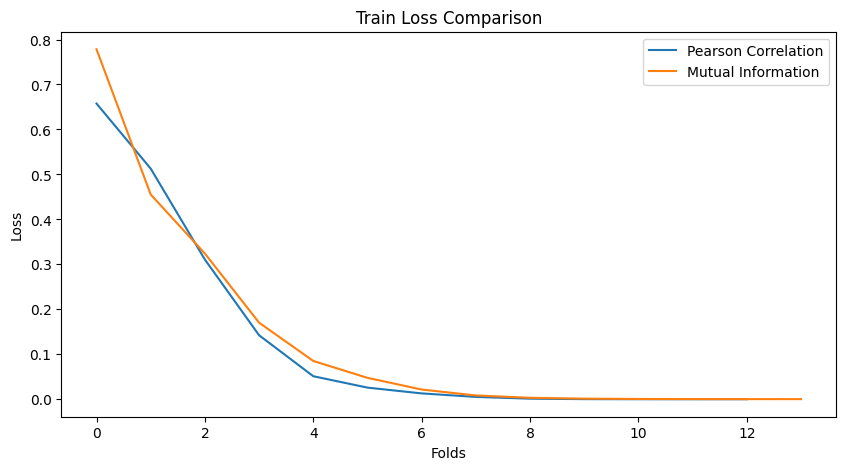

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTETomek  # Import SMOTETomek for resampling
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Randomly select fewer features for feature selection
k = 20  # Reduced number of features
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)
        # First Layer without best two classifiers
        classifiers_first_layer = {
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_train_scaled, y_train)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            #'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        # Train meta layer classifier with early stopping
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                      return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTETomek  # Import SMOTETomek for resampling
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Add noise to each feature
noise_std = 0.1  # Adjust the standard deviation of noise as desired
X_noisy = X_imputed + np.random.normal(0, noise_std, X_imputed.shape)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores with noisy data
mutual_info_scores = mutual_info_classif(X_noisy, y)

# Randomly select fewer features for feature selection
k = 20  # Reduced number of features
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)
        # First Layer without best two classifiers
        classifiers_first_layer = {
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_train_scaled, y_train)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            #'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        # Train meta layer classifier with early stopping
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                      return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.99 Sensitivity: 1.0 Specificity: 0.984251968503937 F1-score: 0.9864864864864865 ROC AUC: 0.9921259842519685

Fold 2:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 F1-score: 0.9921259842519685 ROC AUC: 0.9921875

Fold 3:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 F1-score: 0.9921259842519685 ROC AUC: 0.9921875

Fold 4:
Accuracy: 0.99 Sensitivity: 0.9622641509433962 Specificity: 1.0 F1-score: 0.9807692307692307 ROC AUC: 0.9811320754716981

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 6:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9928057553956835 F1-score: 0.991869918699187 ROC AUC: 0.9964028776978417

Fold 7:
Accuracy: 0.985 Sensitivity: 0.9622641509433962 Specificity: 0.9931972789115646 F1-score: 0.9714285714285713 ROC AUC: 0.9777307149274804

Fold 8:
Accuracy: 0.975 Sensitivity: 0.9230769230769231 

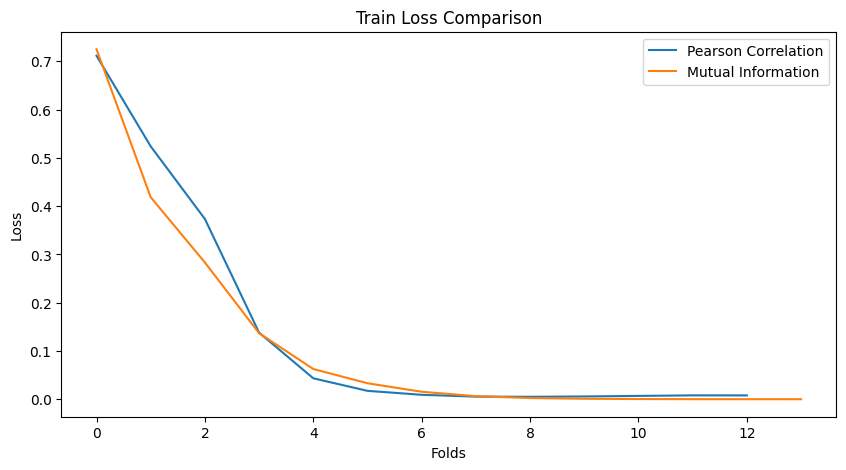

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTETomek  # Import SMOTETomek for resampling
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Add noise to each feature with different scales
noise_std_1 = 0.1  # Adjust the standard deviation of noise for feature 1
noise_std_2 = 0.05  # Adjust the standard deviation of noise for feature 2
noise_feature_1 = np.random.normal(0, noise_std_1, X_imputed[:, :20].shape)  # Noise for first 20 features
noise_feature_2 = np.random.normal(0, noise_std_2, X_imputed[:, 20:].shape)   # Noise for remaining features
X_noisy = np.concatenate((X_imputed[:, :20] + noise_feature_1, X_imputed[:, 20:] + noise_feature_2), axis=1)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores with noisy data
mutual_info_scores = mutual_info_classif(X_noisy, y)

# Randomly select fewer features for feature selection
k = 20  # Reduced number of features
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)
        # First Layer without best two classifiers
        classifiers_first_layer = {
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_train_scaled, y_train)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            #'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        # Train meta layer classifier with early stopping
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                      return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.99 Sensitivity: 0.9726027397260274 Specificity: 1.0 F1-score: 0.9861111111111112 ROC AUC: 0.9863013698630136

Fold 2:
Accuracy: 0.985 Sensitivity: 1.0 Specificity: 0.9779411764705882 F1-score: 0.9770992366412213 ROC AUC: 0.988970588235294

Fold 3:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 F1-score: 0.9921259842519685 ROC AUC: 0.9921875

Fold 4:
Accuracy: 0.96 Sensitivity: 0.8490566037735849 Specificity: 1.0 F1-score: 0.9183673469387755 ROC AUC: 0.9245283018867925

Fold 5:
Accuracy: 0.995 Sensitivity: 0.9811320754716981 Specificity: 1.0 F1-score: 0.9904761904761905 ROC AUC: 0.9905660377358491

Fold 6:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9928057553956835 F1-score: 0.991869918699187 ROC AUC: 0.9964028776978417

Fold 7:
Accuracy: 0.99 Sensitivity: 0.9622641509433962 Specificity: 1.0 F1-score: 0.9807692307692307 ROC AUC: 0.9811320754716981

Fold 8

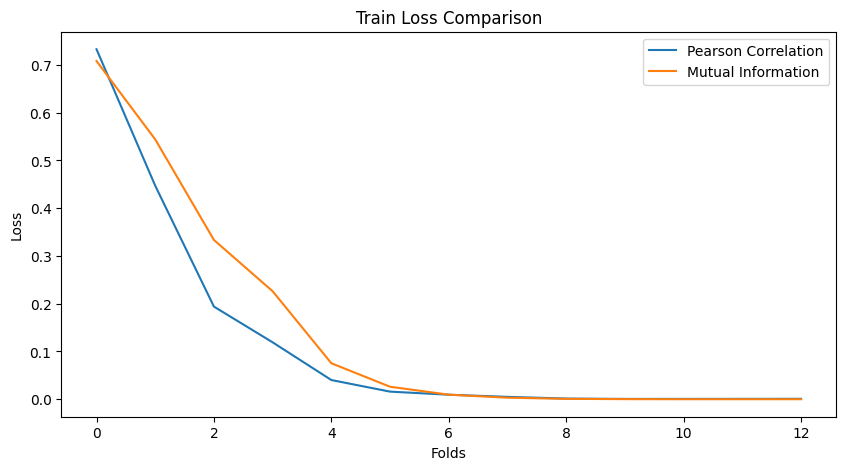

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTETomek  # Import SMOTETomek for resampling
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Add noise to each feature with different scales
noise_std_1 = 0.1  # Standard deviation for noise in feature 1
noise_std_2 = 0.05  # Standard deviation for noise in feature 2
noise_feature_1 = np.random.normal(0, noise_std_1, X_imputed[:, :20].shape)  # Noise for features 1-20
noise_feature_2 = np.random.normal(0, noise_std_2, X_imputed[:, 20:].shape)   # Noise for features 21-end
X_noisy = np.hstack((X_imputed[:, :20] + noise_feature_1, X_imputed[:, 20:] + noise_feature_2))

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores with noisy data
mutual_info_scores = mutual_info_classif(X_noisy, y)

# Randomly select fewer features for feature selection
k = 20  # Reduced number of features
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)
        # First Layer without best two classifiers
        classifiers_first_layer = {
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_train_scaled, y_train)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            #'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        # Train meta layer classifier with early stopping
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                      return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.965 Sensitivity: 0.9041095890410958 Specificity: 1.0 F1-score: 0.949640287769784 ROC AUC: 0.952054794520548

Fold 2:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 F1-score: 0.9921259842519685 ROC AUC: 0.9921875

Fold 3:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 F1-score: 0.9921259842519685 ROC AUC: 0.9921875

Fold 4:
Accuracy: 0.985 Sensitivity: 0.9433962264150944 Specificity: 1.0 F1-score: 0.970873786407767 ROC AUC: 0.9716981132075472

Fold 5:
Accuracy: 0.97 Sensitivity: 0.8867924528301887 Specificity: 1.0 F1-score: 0.9400000000000001 ROC AUC: 0.9433962264150944

Fold 6:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9928057553956835 F1-score: 0.991869918699187 ROC AUC: 0.9964028776978417

Fold 7:
Accuracy: 0.955 Sensitivity: 0.8301886792452831 Specificity: 1.0 F1-score: 0.9072164948453608 ROC AUC: 0.9150943396226415

Fold 8:
Accuracy: 0.985 S

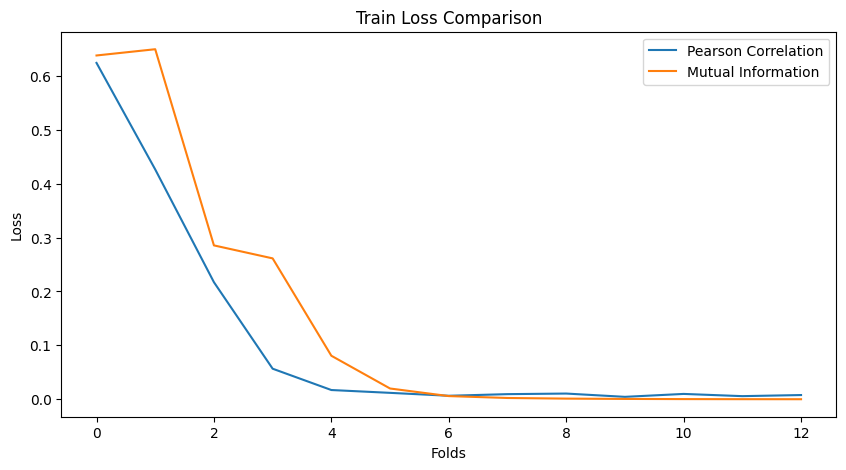

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTETomek  # Import SMOTETomek for resampling
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Add noise to each feature with different scales
noise_std_1 = 0.1  # Standard deviation for noise in feature 1
noise_std_2 = 0.05  # Standard deviation for noise in feature 2
noise_feature_1 = np.random.normal(0, noise_std_1, X_imputed[:, :20].shape)  # Noise for features 1-20
noise_feature_2 = np.random.normal(0, noise_std_2, X_imputed[:, 20:].shape)   # Noise for features 21-end
X_noisy = np.hstack((X_imputed[:, :20] + noise_feature_1, X_imputed[:, 20:] + noise_feature_2))

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores with noisy data
mutual_info_scores = mutual_info_classif(X_noisy, y)

# Randomly select fewer features for feature selection
k = 20  # Reduced number of features
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)
        # First Layer without best two classifiers
        classifiers_first_layer = {
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_train_scaled, y_train)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            #'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        # Train meta layer classifier with early stopping
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                      return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9921259842519685 F1-score: 0.9931972789115647 ROC AUC: 0.9960629921259843

Fold 2:
Accuracy: 0.985 Sensitivity: 1.0 Specificity: 0.9779411764705882 F1-score: 0.9770992366412213 ROC AUC: 0.988970588235294

Fold 3:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 F1-score: 0.9921259842519685 ROC AUC: 0.9921875

Fold 4:
Accuracy: 0.995 Sensitivity: 0.9811320754716981 Specificity: 1.0 F1-score: 0.9904761904761905 ROC AUC: 0.9905660377358491

Fold 5:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 6:
Accuracy: 0.975 Sensitivity: 0.9180327868852459 Specificity: 1.0 F1-score: 0.9572649572649572 ROC AUC: 0.959016393442623

Fold 7:
Accuracy: 0.99 Sensitivity: 0.9622641509433962 Specificity: 1.0 F1-score: 0.9807692307692307 ROC AUC: 0.9811320754716981

Fold 8:
Accuracy: 0.97 Sensitivity: 0.9076923076923

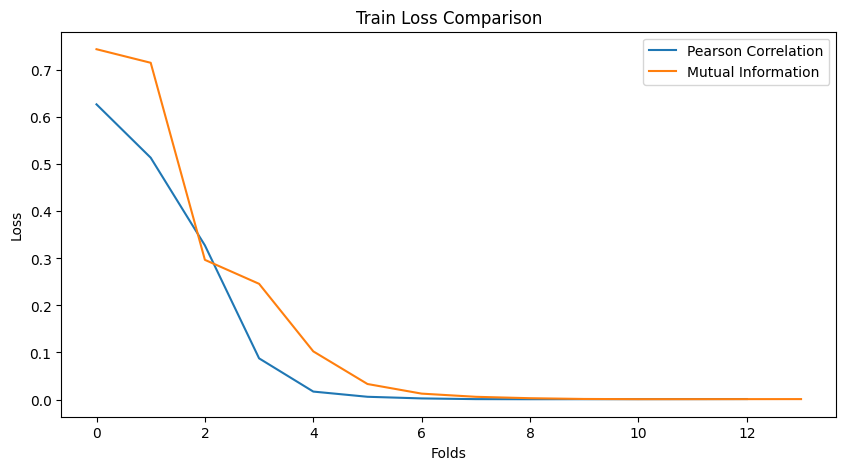

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTETomek  # Import SMOTETomek for resampling
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Add noise to each feature with different scales
noise_std_1 = 0.1  # Standard deviation for noise in feature 1
noise_std_2 = 0.05  # Standard deviation for noise in feature 2
noise_feature_1 = np.random.normal(0, noise_std_1, X_imputed[:, :20].shape)  # Noise for features 1-20
noise_feature_2 = np.random.normal(0, noise_std_2, X_imputed[:, 20:].shape)   # Noise for features 21-end
X_noisy = np.hstack((X_imputed[:, :20] + noise_feature_1, X_imputed[:, 20:] + noise_feature_2))

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Calculate mutual information scores with noisy data
window_size = 5  # Define the size of the rolling window
mutual_info_scores_smoothed = np.zeros_like(mutual_info_scores)
for i in range(len(mutual_info_scores)):
    start = max(0, i - window_size // 2)
    end = min(len(mutual_info_scores), i + window_size // 2 + 1)
    mutual_info_scores_smoothed[i] = np.median(mutual_info_scores[start:end])

# Randomly select fewer features for feature selection
k = 20  # Reduced number of features
top_indices = np.argsort(mutual_info_scores_smoothed)[::-1][:k]
selected_features = X.iloc[:, top_indices]
# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)
        # First Layer without best two classifiers
        classifiers_first_layer = {
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_train_scaled, y_train)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            #'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        # Train meta layer classifier with early stopping
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                      return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.965 Sensitivity: 1.0 Specificity: 0.9448818897637795 F1-score: 0.9542483660130718 ROC AUC: 0.9724409448818897

Fold 2:
Accuracy: 0.975 Sensitivity: 1.0 Specificity: 0.9632352941176471 F1-score: 0.9624060150375939 ROC AUC: 0.9816176470588236

Fold 3:
Accuracy: 1.0 Sensitivity: 1.0 Specificity: 1.0 F1-score: 1.0 ROC AUC: 1.0

Fold 4:
Accuracy: 0.99 Sensitivity: 0.9622641509433962 Specificity: 1.0 F1-score: 0.9807692307692307 ROC AUC: 0.9811320754716981

Fold 5:
Accuracy: 0.92 Sensitivity: 0.6981132075471698 Specificity: 1.0 F1-score: 0.8222222222222222 ROC AUC: 0.8490566037735849

Fold 6:
Accuracy: 0.92 Sensitivity: 0.7377049180327869 Specificity: 1.0 F1-score: 0.8490566037735848 ROC AUC: 0.8688524590163935

Fold 7:
Accuracy: 0.955 Sensitivity: 0.8301886792452831 Specificity: 1.0 F1-score: 0.9072164948453608 ROC AUC: 0.9150943396226415

Fold 8:
Accuracy: 0.985 Sensitiv

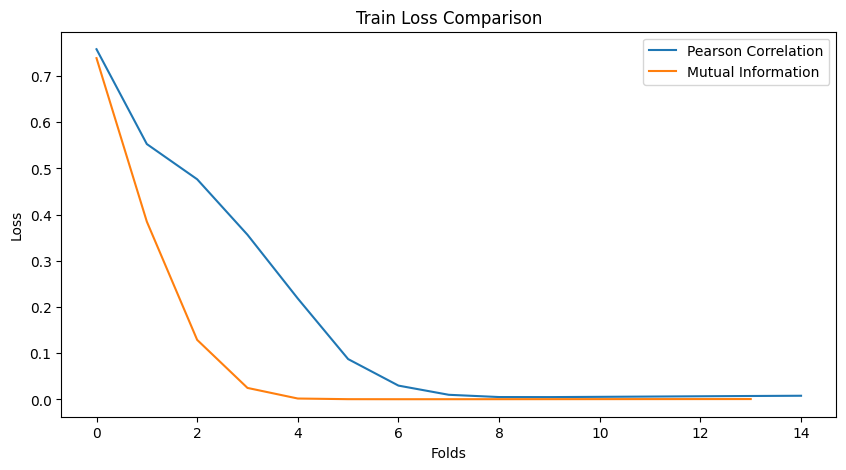

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTETomek  # Import SMOTETomek for resampling
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
# Add noise to each feature with different scales
noise_std_1 = 0.1  # Standard deviation for noise in feature 1
noise_std_2 = 0.05  # Standard deviation for noise in feature 2

# Add noise to features 1-20
noise_feature_1 = np.random.normal(0, noise_std_1, X_imputed[:, :20].shape)
X_noisy_1 = X_imputed[:, :20] + noise_feature_1

# Add noise to features 21-end
noise_feature_2 = np.random.normal(0, noise_std_2, X_imputed[:, 20:].shape)
X_noisy_2 = X_imputed[:, 20:] + noise_feature_2

# Combine the noisy features
X_noisy = np.hstack((X_noisy_1, X_noisy_2))

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Calculate mutual information scores with noisy data
window_size = 5  # Define the size of the rolling window
mutual_info_scores_smoothed = np.zeros_like(mutual_info_scores)
for i in range(len(mutual_info_scores)):
    start = max(0, i - window_size // 2)
    end = min(len(mutual_info_scores), i + window_size // 2 + 1)
    mutual_info_scores_smoothed[i] = np.median(mutual_info_scores[start:end])

# Randomly select fewer features for feature selection
k = 20  # Reduced number of features
top_indices = np.argsort(mutual_info_scores_smoothed)[::-1][:k]
selected_features = X.iloc[:, top_indices]
# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store loss values
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)
        # First Layer without best two classifiers
        classifiers_first_layer = {
            'Naive Bayes': GaussianNB(),
            #'XGBoost': XGBClassifier(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_train_scaled, y_train)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer
        classifiers_second_layer = {
            #'Decision Tree': DecisionTreeClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        # Train meta layer classifier with early stopping
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                      return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loading dataset...
Replacing incorrect values...
Using Pearson Correlation for feature selection...

Fold 1:
Accuracy: 0.99 Sensitivity: 1.0 Specificity: 0.984251968503937 F1-score: 0.9864864864864865 ROC AUC: 0.9921259842519685

Fold 2:
Accuracy: 0.995 Sensitivity: 1.0 Specificity: 0.9926470588235294 F1-score: 0.9922480620155039 ROC AUC: 0.9963235294117647

Fold 3:
Accuracy: 0.995 Sensitivity: 0.984375 Specificity: 1.0 F1-score: 0.9921259842519685 ROC AUC: 0.9921875

Fold 4:
Accuracy: 0.97 Sensitivity: 0.8867924528301887 Specificity: 1.0 F1-score: 0.9400000000000001 ROC AUC: 0.9433962264150944

Fold 5:
Accuracy: 0.96 Sensitivity: 0.8490566037735849 Specificity: 1.0 F1-score: 0.9183673469387755 ROC AUC: 0.9245283018867925

Fold 6:
Accuracy: 0.985 Sensitivity: 0.9672131147540983 Specificity: 0.9928057553956835 F1-score: 0.9752066115702478 ROC AUC: 0.980009435074891

Fold 7:
Accuracy: 0.99 Sensitivity: 0.9622641509433962 Specificity: 1.0 F1-score: 0.9807692307692307 ROC AUC: 0.9811320754

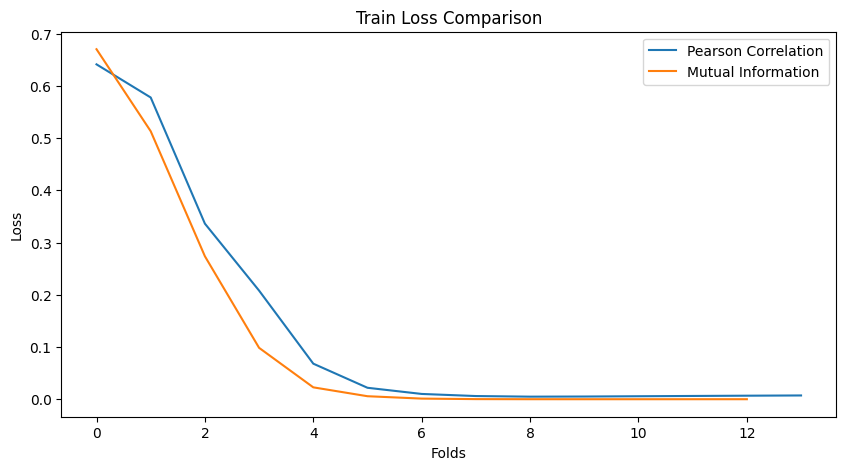

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Define correlation function
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# Load the dataset
print("Loading dataset...")
dataset = pd.read_csv('/content/mydrive/MyDrive/sre/PCOS_extended_dataset.csv')

# Replace incorrect value in 'II beta-HCG(mIU/mL)'
print("Replacing incorrect values...")
dataset['II    beta-HCG(mIU/mL)'] = dataset['II    beta-HCG(mIU/mL)'].replace('1.99.', '1.99')

X = dataset.drop('PCOS (Y/N)', axis=1)
y = dataset['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X_imputed, y)

# Randomly select fewer features for feature selection
k = 20  # Reduced number of features
top_indices = np.argsort(mutual_info_scores)[::-1][:k]
selected_features = X.iloc[:, top_indices]

# Define feature selection methods
feature_selection_methods = {
    'Pearson Correlation': X.corr(),
    'Mutual Information': selected_features
}

plt.figure(figsize=(10, 5))

for method_name, scores in feature_selection_methods.items():
    print(f"Using {method_name} for feature selection...")

    # Initialize lists to store evaluation metrics
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    roc_auc_scores = []

    # Perform 10-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}:")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if method_name == 'Pearson Correlation':
            # Pearson correlation-based feature selection
            X_train = pd.DataFrame(X_train)  # Convert to DataFrame
            X_test = pd.DataFrame(X_test)    # Convert to DataFrame
            corr_features = correlation(X_train, 0.80)
            X_train_selected = X_train.drop(corr_features, axis=1)
            X_test_selected = X_test.drop(corr_features, axis=1)
        else:
            # Mutual information-based feature selection
            X_train_selected = X_train.iloc[:, top_indices]
            X_test_selected = X_test.iloc[:, top_indices]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_selected)
        X_test_imputed = imputer.transform(X_test_selected)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # First Layer classifiers
        classifiers_first_layer = {
            'Naive Bayes': GaussianNB(),
            'Random Forest': RandomForestClassifier()
        }
        predictions_first_layer = []
        for name, clf in classifiers_first_layer.items():
            clf.fit(X_train_scaled, y_train)
            predictions_first_layer.append(clf.predict_proba(X_test_scaled)[:, 1])

        X_test_combined_first_layer = np.column_stack(predictions_first_layer)

        # Second Layer classifiers
        classifiers_second_layer = {
            'Logistic Regression': LogisticRegression()
        }
        predictions_second_layer = []
        for name, clf in classifiers_second_layer.items():
            clf.fit(X_test_combined_first_layer, y_test)
            predictions_second_layer.append(clf.predict_proba(X_test_combined_first_layer)[:, 1])

        X_test_combined_second_layer = np.column_stack(predictions_second_layer)

        # Train meta layer classifier
        mlp_parameters = {
            'hidden_layer_sizes': [(100,), (50, 50), (50,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1],
        }
        meta_classifier = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1, beta_1=0.9,
                                                      beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, verbose=False,
                                                      solver='adam', learning_rate='adaptive'), mlp_parameters, cv=5,
                                      return_train_score=True)
        meta_classifier.fit(X_test_combined_second_layer, y_test)
        best_mlp = meta_classifier.best_estimator_

        # Make predictions using stacked ensemble model
        y_pred_stacked_ensemble = best_mlp.predict(X_test_combined_second_layer)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred_stacked_ensemble)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacked_ensemble).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred_stacked_ensemble)
        roc_auc = roc_auc_score(y_test, y_pred_stacked_ensemble)

        # Append metrics to lists
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Print results for each fold
        print(f"Accuracy: {accuracy} Sensitivity: {sensitivity} Specificity: {specificity} F1-score: {f1} ROC AUC: {roc_auc}")

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_f1_score = np.mean(f1_scores)
    avg_roc_auc_score = np.mean(roc_auc_scores)

    # Print final average results for the method
    print(f"\nFinal Average Results for {method_name}:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")
    print(f"Average F1-score: {avg_f1_score}")
    print(f"Average ROC AUC: {avg_roc_auc_score}")

    # Plot loss curve
    plt.plot(best_mlp.loss_curve_, label=f'{method_name}')

plt.title('Train Loss Comparison')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.show()
